# 1. Recommendation system

In [6]:
#!pip install datasketch
# !pip install ydata_profiling

In [8]:
import numpy as np
import pandas as pd
import re
import time
from datasketch import MinHash, MinHashLSHForest
import csv
from ydata_profiling import ProfileReport
from itertools import chain


In [20]:
df = pd.read_csv('vodclickstream_uk_movies_03.csv')
dataset = df
df.head()


Unnamed: 0             datetime  duration  \
0       58773  2017-01-01 01:15:09       0.0   
1       58774  2017-01-01 13:56:02       0.0   
2       58775  2017-01-01 15:17:47   10530.0   
3       58776  2017-01-01 16:04:13      49.0   
4       58777  2017-01-01 19:16:37       0.0   

                                title  \
0  Angus, Thongs and Perfect Snogging   
1        The Curse of Sleeping Beauty   
2                   London Has Fallen   
3                            Vendetta   
4     The SpongeBob SquarePants Movie   

                                              genres release_date    movie_id  \
0                             Comedy, Drama, Romance   2008-07-25  26bd5987e8   
1                 Fantasy, Horror, Mystery, Thriller   2016-06-02  f26ed2675e   
2                                   Action, Thriller   2016-03-04  f77e500e7a   
3                                      Action, Drama   2015-06-12  c74aec7673   
4  Animation, Action, Adventure, Comedy, Family, ...   2004-11-19  a80d6fc2aa   

      user_id  
0  1dea19f6fe  
1  544dcbc510  
2  7cbcc791bf  
3  ebf43c36b6  
4  a57c992287

### A little bit of data cleaning first

In [ ]:
df["datetime"]=pd.to_datetime(df["datetime"])
df["release_date"]=pd.to_datetime(df["release_date"],errors="coerce")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    671736 non-null  int64         
 1   datetime      671736 non-null  datetime64[ns]
 2   duration      671736 non-null  float64       
 3   title         671736 non-null  object        
 4   genres        671736 non-null  object        
 5   release_date  641432 non-null  datetime64[ns]
 6   movie_id      671736 non-null  object        
 7   user_id       671736 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 41.0+ MB


We create a new column containing the genres for each row in a list instead of a string like in the "genres" column

In [ ]:
df['genres_list'] = df.genres.apply(lambda row: [word.strip() for word in row.split(',')])
df

Unnamed: 0            datetime  duration  \
0            58773 2017-01-01 01:15:09       0.0   
1            58774 2017-01-01 13:56:02       0.0   
2            58775 2017-01-01 15:17:47   10530.0   
3            58776 2017-01-01 16:04:13      49.0   
4            58777 2017-01-01 19:16:37       0.0   
...            ...                 ...       ...   
671731      730504 2019-06-30 21:37:08     851.0   
671732      730505 2019-06-30 21:49:34   91157.0   
671733      730506 2019-06-30 22:00:44       0.0   
671734      730507 2019-06-30 22:04:23       0.0   
671735      730508 2019-06-30 22:35:24       0.0   

                                            title  \
0              Angus, Thongs and Perfect Snogging   
1                    The Curse of Sleeping Beauty   
2                               London Has Fallen   
3                                        Vendetta   
4                 The SpongeBob SquarePants Movie   
...                                           ...   
671731        Oprah Presents When They See Us Now   
671732                               HALO Legends   
671733                                Pacific Rim   
671734  ReMastered: The Two Killings of Sam Cooke   
671735                                 Chopsticks   

                                                   genres release_date  \
0                                  Comedy, Drama, Romance   2008-07-25   
1                      Fantasy, Horror, Mystery, Thriller   2016-06-02   
2                                        Action, Thriller   2016-03-04   
3                                           Action, Drama   2015-06-12   
4       Animation, Action, Adventure, Comedy, Family, ...   2004-11-19   
...                                                   ...          ...   
671731                                          Talk-Show   2019-06-12   
671732       Animation, Action, Adventure, Family, Sci-Fi   2010-02-16   
671733                          Action, Adventure, Sci-Fi   2013-07-12   
671734                                 Documentary, Music   2019-02-08   
671735                                      Comedy, Drama   2019-05-31   

          movie_id     user_id  \
0       26bd5987e8  1dea19f6fe   
1       f26ed2675e  544dcbc510   
2       f77e500e7a  7cbcc791bf   
3       c74aec7673  ebf43c36b6   
4       a80d6fc2aa  a57c992287   
...            ...         ...   
671731  43cd23f30f  57501964fd   
671732  febf42d55f  d4fcb079ba   
671733  7b15e5ada1  4a14a2cd5a   
671734  52d49c515a  0b8163ea4b   
671735  0be62aac8b  5e5755d816   

                                              genres_list  
0                                [Comedy, Drama, Romance]  
1                    [Fantasy, Horror, Mystery, Thriller]  
2                                      [Action, Thriller]  
3                                         [Action, Drama]  
4       [Animation, Action, Adventure, Comedy, Family,...  
...                                                   ...  
671731                                        [Talk-Show]  
671732     [Animation, Action, Adventure, Family, Sci-Fi]  
671733                        [Action, Adventure, Sci-Fi]  
671734                               [Documentary, Music]  
671735                                    [Comedy, Drama]  

[671736 rows x 9 columns]

Here we created a set containing all the unique genres in the dataframe

In [ ]:
genres=df["genres"].to_frame()
uni=[]
for i in range(len(genres)):
    x=genres["genres"][i].split(', ')
    for j in x:
        uni.append(j)

uni=set(uni)
uni


{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'NOT AVAILABLE',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

We remove the genre : NOT AVAILABLE

In [ ]:
uni.remove("NOT AVAILABLE")
uni

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [ ]:
df = df.drop('Unnamed: 0', axis=1)


In [ ]:
x="NOT AVAILABLE"
for i in df["genres_list"]:
    if x in i:
        i.remove(x)

# WE removed "NOT AVAILABLE" from the data frame


This is the data frame we will use for the Recommendation system

In [ ]:
df

datetime  duration  \
0      2017-01-01 01:15:09       0.0   
1      2017-01-01 13:56:02       0.0   
2      2017-01-01 15:17:47   10530.0   
3      2017-01-01 16:04:13      49.0   
4      2017-01-01 19:16:37       0.0   
...                    ...       ...   
671731 2019-06-30 21:37:08     851.0   
671732 2019-06-30 21:49:34   91157.0   
671733 2019-06-30 22:00:44       0.0   
671734 2019-06-30 22:04:23       0.0   
671735 2019-06-30 22:35:24       0.0   

                                            title  \
0              Angus, Thongs and Perfect Snogging   
1                    The Curse of Sleeping Beauty   
2                               London Has Fallen   
3                                        Vendetta   
4                 The SpongeBob SquarePants Movie   
...                                           ...   
671731        Oprah Presents When They See Us Now   
671732                               HALO Legends   
671733                                Pacific Rim   
671734  ReMastered: The Two Killings of Sam Cooke   
671735                                 Chopsticks   

                                                   genres release_date  \
0                                  Comedy, Drama, Romance   2008-07-25   
1                      Fantasy, Horror, Mystery, Thriller   2016-06-02   
2                                        Action, Thriller   2016-03-04   
3                                           Action, Drama   2015-06-12   
4       Animation, Action, Adventure, Comedy, Family, ...   2004-11-19   
...                                                   ...          ...   
671731                                          Talk-Show   2019-06-12   
671732       Animation, Action, Adventure, Family, Sci-Fi   2010-02-16   
671733                          Action, Adventure, Sci-Fi   2013-07-12   
671734                                 Documentary, Music   2019-02-08   
671735                                      Comedy, Drama   2019-05-31   

          movie_id     user_id  \
0       26bd5987e8  1dea19f6fe   
1       f26ed2675e  544dcbc510   
2       f77e500e7a  7cbcc791bf   
3       c74aec7673  ebf43c36b6   
4       a80d6fc2aa  a57c992287   
...            ...         ...   
671731  43cd23f30f  57501964fd   
671732  febf42d55f  d4fcb079ba   
671733  7b15e5ada1  4a14a2cd5a   
671734  52d49c515a  0b8163ea4b   
671735  0be62aac8b  5e5755d816   

                                              genres_list  
0                                [Comedy, Drama, Romance]  
1                    [Fantasy, Horror, Mystery, Thriller]  
2                                      [Action, Thriller]  
3                                         [Action, Drama]  
4       [Animation, Action, Adventure, Comedy, Family,...  
...                                                   ...  
671731                                        [Talk-Show]  
671732     [Animation, Action, Adventure, Family, Sci-Fi]  
671733                        [Action, Adventure, Sci-Fi]  
671734                               [Documentary, Music]  
671735                                    [Comedy, Drama]  

[671736 rows x 8 columns]

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We created a dictionary containing all the single Netflix users linked to the genres they watch on the streming platform

In [ ]:
user_genres={}

for i in range(len(df)):
    id=df["user_id"][i]
    gen=set(df["genres_list"][i])
    if id not in user_genres:
        user_genres[id]=gen
    user_genres[id].update(gen)


In [ ]:
len(user_genres)

# 161918 different users

161918

### EXERCISE 1.1

In [ ]:
# We count the number of clicks = "count" for each film and user
sorted_df=(df.groupby(["user_id","movie_id"]).size().reset_index(name="count")).sort_values(by=["user_id","count"],ascending=[True,False])
# We keep just the top 10 most clicked films
top_10 =sorted_df.groupby("user_id").head(10)
# Now we proceed by merging the top_10 datframe with the "title" and "genre" info about the movies
merged_df = pd.merge(top_10, df[["user_id","movie_id","title", "genres"]], on=["movie_id","user_id"], how="left")
merged_df # There are a lot of duplicates

user_id    movie_id  count               title  \
0       00004e2862  9bfee795ff      1            Hannibal   
1       000052a0a0  4718f9963c      9              Looper   
2       000052a0a0  4718f9963c      9              Looper   
3       000052a0a0  4718f9963c      9              Looper   
4       000052a0a0  4718f9963c      9              Looper   
...            ...         ...    ...                 ...   
613389  fffeac83be  a2d8a56924      1         Son of Saul   
613390  fffeac83be  dda0eae17b      1  Enemy at the Gates   
613391  ffff2c5f9e  6467fee6b6      1            Hot Fuzz   
613392  ffff2c5f9e  9ab62a3f2c      1   Forks Over Knives   
613393  ffffd36adf  9d1f4fb4fb      1    Dead Man Walking   

                                   genres  
0                  Crime, Drama, Thriller  
1         Action, Drama, Sci-Fi, Thriller  
2         Action, Drama, Sci-Fi, Thriller  
3         Action, Drama, Sci-Fi, Thriller  
4         Action, Drama, Sci-Fi, Thriller  
...                                   ...  
613389                         Drama, War  
613390                Drama, History, War  
613391  Action, Comedy, Mystery, Thriller  
613392                        Documentary  
613393                       Crime, Drama  

[613394 rows x 5 columns]

In [ ]:
merged_df=merged_df.drop_duplicates()
merged_df

user_id    movie_id  count               title  \
0       00004e2862  9bfee795ff      1            Hannibal   
1       000052a0a0  4718f9963c      9              Looper   
10      000052a0a0  4fa0b092d6      3             Jumanji   
13      000052a0a0  7314699c23      3             Frailty   
16      000052a0a0  6275614f9a      2       Resident Evil   
...            ...         ...    ...                 ...   
613389  fffeac83be  a2d8a56924      1         Son of Saul   
613390  fffeac83be  dda0eae17b      1  Enemy at the Gates   
613391  ffff2c5f9e  6467fee6b6      1            Hot Fuzz   
613392  ffff2c5f9e  9ab62a3f2c      1   Forks Over Knives   
613393  ffffd36adf  9d1f4fb4fb      1    Dead Man Walking   

                                    genres  
0                   Crime, Drama, Thriller  
1          Action, Drama, Sci-Fi, Thriller  
10      Adventure, Comedy, Family, Fantasy  
13                  Crime, Drama, Thriller  
16                  Action, Horror, Sci-Fi  
...                                    ...  
613389                          Drama, War  
613390                 Drama, History, War  
613391   Action, Comedy, Mystery, Thriller  
613392                         Documentary  
613393                        Crime, Drama  

[446676 rows x 5 columns]

The df above shows for each user the top 10 films he saw with the relative number of clicks, the movies' genres and title.

### EXERCISE 1.2

Now our aim is to create from scratch a minhash function in order to make users with similar interests in a genre appear in the same bucket.

In [ ]:
signature_matrix=pd.DataFrame(index=user_genres.keys(),columns=sorted(list(uni)))
signature_matrix

Action Adventure Animation Biography Comedy Crime Documentary  \
1dea19f6fe    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
544dcbc510    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
7cbcc791bf    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
ebf43c36b6    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
a57c992287    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
...           ...       ...       ...       ...    ...   ...         ...   
45414be0ec    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
783ec67e84    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
89c715f3a4    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
9207e1499b    NaN       NaN       NaN       NaN    NaN   NaN         NaN   
57501964fd    NaN       NaN       NaN       NaN    NaN   NaN         NaN   

           Drama Family Fantasy  ... News Reality-TV Romance Sci-Fi Short  \
1dea19f6fe   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
544dcbc510   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
7cbcc791bf   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
ebf43c36b6   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
a57c992287   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
...          ...    ...     ...  ...  ...        ...     ...    ...   ...   
45414be0ec   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
783ec67e84   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
89c715f3a4   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
9207e1499b   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   
57501964fd   NaN    NaN     NaN  ...  NaN        NaN     NaN    NaN   NaN   

           Sport Talk-Show Thriller  War Western  
1dea19f6fe   NaN       NaN      NaN  NaN     NaN  
544dcbc510   NaN       NaN      NaN  NaN     NaN  
7cbcc791bf   NaN       NaN      NaN  NaN     NaN  
ebf43c36b6   NaN       NaN      NaN  NaN     NaN  
a57c992287   NaN       NaN      NaN  NaN     NaN  
...          ...       ...      ...  ...     ...  
45414be0ec   NaN       NaN      NaN  NaN     NaN  
783ec67e84   NaN       NaN      NaN  NaN     NaN  
89c715f3a4   NaN       NaN      NaN  NaN     NaN  
9207e1499b   NaN       NaN      NaN  NaN     NaN  
57501964fd   NaN       NaN      NaN  NaN     NaN  

[161918 rows x 26 columns]

In [ ]:
for user, genres in user_genres.items():
    for i in genres:
        signature_matrix.loc[user][i]=1

The matrix we are creating has for each user a 0 for a genre he didn't watch and a 1 for each genre he watched

In [ ]:
signature_matrix=signature_matrix.fillna(0)
signature_matrix

Action  Adventure  Animation  Biography  Comedy  Crime  \
1dea19f6fe       0          0          0          0       1      0   
544dcbc510       0          1          0          0       1      0   
7cbcc791bf       1          1          1          0       1      1   
ebf43c36b6       1          1          1          1       1      1   
a57c992287       1          1          1          1       1      1   
...            ...        ...        ...        ...     ...    ...   
45414be0ec       0          0          0          0       1      0   
783ec67e84       0          0          0          1       0      0   
89c715f3a4       0          1          1          0       1      0   
9207e1499b       0          0          0          1       0      1   
57501964fd       0          0          0          0       0      0   

            Documentary  Drama  Family  Fantasy  ...  News  Reality-TV  \
1dea19f6fe            0      1       0        0  ...     0           0   
544dcbc510            0      1       0        1  ...     0           0   
7cbcc791bf            0      0       1        1  ...     0           0   
ebf43c36b6            0      1       1        1  ...     0           0   
a57c992287            1      1       1        1  ...     0           0   
...                 ...    ...     ...      ...  ...   ...         ...   
45414be0ec            0      0       0        0  ...     0           0   
783ec67e84            0      1       0        0  ...     0           0   
89c715f3a4            0      0       1        1  ...     0           0   
9207e1499b            0      1       0        0  ...     0           0   
57501964fd            0      0       0        0  ...     0           0   

            Romance  Sci-Fi  Short  Sport  Talk-Show  Thriller  War  Western  
1dea19f6fe        1       0      0      0          0         0    0        0  
544dcbc510        1       0      0      0          0         1    0        0  
7cbcc791bf        1       0      0      0          0         1    0        0  
ebf43c36b6        0       1      0      0          0         1    0        0  
a57c992287        0       1      1      1          0         1    1        1  
...             ...     ...    ...    ...        ...       ...  ...      ...  
45414be0ec        1       0      0      0          0         0    0        0  
783ec67e84        0       0      0      1          0         0    0        0  
89c715f3a4        0       1      0      0          0         0    0        0  
9207e1499b        0       0      0      0          0         0    0        0  
57501964fd        0       0      0      0          1         0    0        0  

[161918 rows x 26 columns]

The next step for our minhash function is to make a number n_perm of permutations on the columns. We select n_perm=15

In [ ]:
sign=[]
num_perm=15
for i in range(num_perm):
    colonne_permutate = np.random.permutation(signature_matrix.columns)
    mat=signature_matrix[colonne_permutate]
    lista=[]
    for i in user_genres.keys():
        lista.append(np.argmax(mat.loc[i])+1)
    sign.append(lista)

The matrix we obtained is a signature matrix where every column represent a permutation and the numbers represent the index where the first 1 appears

In [ ]:
df=pd.DataFrame(sign).T
df = df.set_index(pd.Index(user_genres.keys()))
df

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
1dea19f6fe   3   5  10  21   5  10  14  16   7   6   8  11   6   3  14
544dcbc510   3   5   2   6   5   2   1   3   7   1   3   3   3   2   3
7cbcc791bf   4   5   5   3   6   1   2   2   2   1   4   3   6   1   1
ebf43c36b6   3   3   5   3   5   1   2   2   2   1   4   3   6   1   1
a57c992287   2   2   1   2   1   1   1   2   2   1   1   1   2   1   1
...         ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
45414be0ec  18   5  10  21  22  10  14  16   8   6  11  11   6   3  14
783ec67e84   3   3   9   5   4  12   8   6   7   4   7   1  10   9   5
89c715f3a4   8   5   5   3   6   1   2   2   2   1   4   3   6   1   1
9207e1499b   3   3   9  20   5   6  12   4   3   4   8  16  10   9  11
57501964fd  16  16  12  14   2  18  22  22   1  12  15   4  13  26  23

[161918 rows x 15 columns]

In [ ]:
# We will divide the matrix above in 4 different sections
b1 =df.iloc[:, :3]
b2 = df.iloc[:, 3:6]
b3 = df.iloc[:, 6:9]
b4 = df.iloc[:, 9:12]
b5 = df.iloc[:, 12:]
bands=[b1,b2,b3,b4,b5]

 We created an empty dictionary called buck and then we updated it by putting as keys the tuples made by the numbers of the first "one" in the
 singature matrix for each permutation in the bands b1,b2,b3,b4 and b5, and to each of these keys we linked a list of all the users with that tuple.
 By doing that we can now compare users and the genres they like much faster.

In [ ]:
buck={}
for b in bands:
    for i in range(len(df)):
        sim=tuple(b.iloc[i])
        if sim not in buck.keys():
            buck[sim]=list()
            buck[sim].append(b.index[i])
        else:
            buck[sim].append(b.index[i])



In [ ]:
print("We created "+ str(len(buck)) +" different buckets")

# Due to the casuality of the permutations the number of buckets created changes each time we run the code

We created 1554 different buckets


**EXERCISE 1.3**

In [ ]:
user_genres
examples=["ebf43c36b6","7cbcc791bf","57501964fd","45414be0ec","89c715f3a4","b15926c011"]

# We defined the variable examples that we will use for testing

In [ ]:
def possible_matches(user_id):
    possible_matchs=[]
    for i in buck.keys():
        if user_id in buck[i]:
            possible_matchs.append(buck[i])

    return set(chain(*possible_matchs))


# This function finds for the user_id queried, all the users he is most likely similar to, by looking at the buckets where the user is located

In [ ]:
ex1=possible_matches(examples[0])
ex2=possible_matches(examples[1])
ex3=possible_matches(examples[2])
ex4=possible_matches(examples[3])
len(ex1),len(ex2),len(ex3),len(ex4)

# We tested the function on 4 randomly picked user_ids

(18833, 17841, 20, 12466)

To measure the similarity between users we decided to use the jaccard similarity as suggested also on the book. The function above computes the jaccard similarity
between two sets

In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


 Once that we found the set with all the possible users similar to the one queried, we can work just on this set instead of using all the ids,
 in order to reduce computational time

In [ ]:

def top2(user_id):
    rec=pd.DataFrame()
    sol=[]
    lik=user_genres[user_id]
    pm=possible_matches(user_id)
    pm.remove(user_id)
    for i in pm:
        lik2=user_genres[i]
        sim=jaccard_similarity(lik,lik2)
        sol.append(sim)
    rec.index=pm
    rec["js"]=sol
    return rec.sort_values("js",ascending=False)


The top2() function returns all the users similar to one queired using the jaccard similarity, a jaccard similarity=1 means that the users like the same genres according to the mihash function reduction

In [ ]:
top2(examples[0])


js
fe7c69b00f  1.000000
d5c7115254  1.000000
b05fb952ba  1.000000
69d2636b5e  1.000000
210fe394e3  1.000000
...              ...
56ef9e10af  0.066667
93fc2d5a33  0.066667
78051dcd3c  0.062500
641f18e9d4  0.062500
d31189d49c  0.000000

[18832 rows x 1 columns]

### EXERCISE 1.3

We wanto to recommend at most five movies to the user to watch based on the movies clicked by similar users. We will follow this guideline:
* Identify the two most similar users to this user. (using top2())
* If these two users have any movies in common, recommend those movies based on the total number of clicks by these users.
* If there are no more common movies, try to propose the most clicked movies by the most similar user first, followed by the other user.


In [ ]:
top2(examples[1])[0:5] # we look at the top 5 results

# if there are some exequo we choose casually one of the user (for example the first one computed)

js
b3b1dddf1e  1.0
acb4180ba2  1.0
7eb46aeec3  1.0
bbc4102c90  1.0
d19c51332f  1.0

We look at the movies seen by the top2 users

In [ ]:
user_1=merged_df[merged_df["user_id"]=="b3b1dddf1e"]
user_1

user_id    movie_id  count                title  \
430178  b3b1dddf1e  252c41b823      2        Kung Fu Panda   
430180  b3b1dddf1e  5723d3932d      2      Shrek the Third   
430182  b3b1dddf1e  1f95de977d      1              Grimsby   
430183  b3b1dddf1e  30ab175630      1    When We First Met   
430184  b3b1dddf1e  b845cd10ea      1       Over the Hedge   
430185  b3b1dddf1e  be0d6bcabe      1      Kung Fu Panda 2   
430186  b3b1dddf1e  d8fe485619      1  Shrek Forever After   

                                                   genres  
430178       Animation, Action, Adventure, Comedy, Family  
430180      Animation, Adventure, Comedy, Family, Fantasy  
430182         Action, Adventure, Comedy, Crime, Thriller  
430183                           Comedy, Fantasy, Romance  
430184      Animation, Adventure, Comedy, Family, Fantasy  
430185  Animation, Action, Adventure, Comedy, Family, ...  
430186  Animation, Adventure, Comedy, Family, Fantasy,...

In [ ]:
user_2=merged_df[merged_df["user_id"]=="acb4180ba2"]
user_2

user_id    movie_id  count                   title  \
413618  acb4180ba2  819a646a75      2                Accepted   
413620  acb4180ba2  039d9da1ad      1  The 40-Year-Old Virgin   
413621  acb4180ba2  1f95de977d      1                 Grimsby   
413622  acb4180ba2  b845cd10ea      1          Over the Hedge   

                                               genres  
413618                                         Comedy  
413620                                Comedy, Romance  
413621     Action, Adventure, Comedy, Crime, Thriller  
413622  Animation, Adventure, Comedy, Family, Fantasy

In [ ]:
rec_movies=[]
film_1=list(user_1["title"].values)
film_2=list(user_2["title"].values)
for i in film_1:
    if i in film_2:
        rec_movies.append(i)

rec_movies


['Grimsby', 'Over the Hedge']

Now after these tests we create the function to return the 5 movies recommended

In [ ]:
def recommend_film(user_id):
    rec_movies=[]
    d=top2(user_id)
    user_1=merged_df[merged_df["user_id"]==d.index[0:2].values[0]]
    user_2=merged_df[merged_df["user_id"]==d.index[0:2].values[1]]
    film_1=list(user_1["title"].values)
    film_2=list(user_2["title"].values)
    for i in film_1:
        if i in film_2:
            rec_movies.append(i)
    for j in film_1:
        if len(rec_movies)==5:
            break
        if j not in rec_movies:
            rec_movies.append(j)
    for k in film_2:
        if len(rec_movies)==5:
            break
        if k not in rec_movies:
            rec_movies.append(k)


    return rec_movies

# The functions looks at first to the common movies and append them to the rec_movies list then if the length of rec_movies is lower
# than 5 it looks to the most clicked films by user_1 and then user_2

We run a few examples looking for any possible error

In [ ]:
recommend_film(examples[1])

['Grimsby',
 'Over the Hedge',
 'Kung Fu Panda',
 'Shrek the Third',
 'When We First Met']

In [ ]:
recommend_film(examples[0])

['Hotel Transylvania 2',
 'The Amazing Spider-Man 2',
 'Bernie',
 'Mercury Rising',
 'Step Brothers']

In [ ]:
recommend_film(examples[2])

['Oprah Presents When They See Us Now']

In [ ]:
recommend_film(examples[5])

['Love, Rosie',
 'Coin Heist',
 'The Edge of Seventeen',
 'Minor Details',
 'Before I Fall']

**************

# 2. Grouping Users together!

### 2.1 Getting your data + feature engineering

In [10]:
from functools import reduce

In [21]:
dataset = dataset[dataset['duration'] >0]
print("Rows where duration is negative:")
print(dataset)


Rows where duration is negative:
        Unnamed: 0             datetime  duration  \
2            58775  2017-01-01 15:17:47   10530.0   
3            58776  2017-01-01 16:04:13      49.0   
6            58779  2017-01-01 19:43:06    4903.0   
8            58781  2017-01-01 19:46:24    3845.0   
11           58784  2017-01-01 20:55:46    6175.0   
...            ...                  ...       ...   
671726      730499  2019-06-30 19:53:16     324.0   
671729      730502  2019-06-30 20:58:53    3128.0   
671730      730503  2019-06-30 21:29:08   42592.0   
671731      730504  2019-06-30 21:37:08     851.0   
671732      730505  2019-06-30 21:49:34   91157.0   

                                      title  \
2                         London Has Fallen   
3                                  Vendetta   
6                         The Water Diviner   
8                                    Ratter   
11                                  28 Days   
...                                     ...   
6

In [22]:
df=dataset
filtered_genre = df.loc[df['user_id'] == '1dea19f6fe', 'genres'].values
print(filtered_genre)

[]


In [23]:
duplicate_user_count = dataset['user_id'].duplicated().sum()
print("Number of duplicate user IDs:", duplicate_user_count)
unique_user_count = dataset['user_id'].nunique()
print("Number of unique user IDs:", unique_user_count)

Number of duplicate user IDs: 240621
Number of unique user IDs: 109761


Since there are multiple duplicate user_ids, this means a single user has watched movies more than one time. So, to align single user's data, we should group by user_id.

In [24]:
dataset['genres_list'] = ''
dataset['genres_list'] = dataset.genres.apply(lambda row: [word.strip() for word in row.split(',')])

In [25]:
unique_genres = set()
dataset['genres_list'].apply(lambda row: [unique_genres.add(value) for value in row])

2                           [None, None]
3                           [None, None]
6                     [None, None, None]
8                     [None, None, None]
11                          [None, None]
                       ...              
671726    [None, None, None, None, None]
671729                            [None]
671730                [None, None, None]
671731                            [None]
671732    [None, None, None, None, None]
Name: genres_list, Length: 350382, dtype: object

In [26]:
unique_genres = reduce(lambda x, y: set(x).union(set(y)), dataset.genres_list)

In [27]:
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'NOT AVAILABLE',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [28]:
df = dataset
# Initialize an empty DataFrame for the result
columns = ['user_id', 'genre', 'count', 'duration']
new_df = pd.DataFrame(columns=columns)

# Expand the genres_list column into separate rows
expanded_df = df.explode('genres_list')

# Filter rows with valid genres
expanded_df = expanded_df[expanded_df['genres_list'].isin(unique_genres)]

# Group by user_id and genre, and aggregate count and duration
grouped_df = expanded_df.groupby(['user_id', 'genres_list']).agg(count=('genres_list', 'count'), duration=('duration', 'sum')).reset_index()

# Rename columns to match the desired output
grouped_df = grouped_df.rename(columns={'genres_list': 'genre'})

# Update the new_df with the grouped data
new_df = pd.concat([new_df, grouped_df], ignore_index=True)

# Convert duration to int for better readability
new_df['duration'] = new_df['duration'].astype(int)

# Display the resulting DataFrame
print(new_df)


           user_id        genre count  duration
0       000052a0a0       Action     7     37270
1       000052a0a0    Adventure     5     15160
2       000052a0a0    Animation     1      4547
3       000052a0a0       Comedy     7     23441
4       000052a0a0        Crime     5     13948
...            ...          ...   ...       ...
530910  fffeac83be  Documentary     3     91570
530911  fffeac83be        Drama     7    355099
530912  fffeac83be      History     2    135799
530913  fffeac83be      Mystery     1      6130
530914  fffeac83be          War     2     50640

[530915 rows x 4 columns]


In [29]:
new_column_names = {
    'user_id': 'user_id',
    'genre': 'fav_genre',
    'count': 'fav_genre_count',
    'duration': 'fav_genre_duration'
}

# Rename the columns using the dictionary
new_df = new_df.rename(columns=new_column_names)

# Rename the columns in place
new_df.rename(columns=new_column_names, inplace=True)


In [30]:
new_df['fav_genre_count'] = new_df['fav_genre_count'].astype(int)

# Get the index of the rows with the maximum count for each user
max_count_indices = new_df.groupby('user_id')['fav_genre_count'].idxmax()

# Filter new_df based on the max_count_indices
new_df_max_count = new_df.loc[max_count_indices]

# Display the resulting DataFrame
new_df_max_count

user_id  fav_genre  fav_genre_count  fav_genre_duration
0       000052a0a0     Action                7               37270
13      000296842d      Drama                4               77308
17      0002aab109  Biography                1               83625
19      0005c8fbac  Adventure                1              344037
26      0005d9a8f4  Adventure                1               14394
...            ...        ...              ...                 ...
530895  fffd345213  Adventure                1                3892
530898  fffd4d1888     Action                1                6714
530901  fffd9bf758      Crime                1                8495
530904  fffe7b777b      Drama                1                1785
530911  fffeac83be      Drama                7              355099

[109761 rows x 4 columns]

In [31]:
unique_user_count_new_df_max_count = new_df_max_count['user_id'].nunique()
unique_user_count_new_df_max_count == unique_user_count


True

In [32]:
merged_df = pd.merge(new_df_max_count, dataset, on='user_id', how='inner')

# Display the resulting merged DataFrame
merged_df

user_id fav_genre  fav_genre_count  fav_genre_duration  Unnamed: 0  \
0       000052a0a0    Action                7               37270      142650   
1       000052a0a0    Action                7               37270      142851   
2       000052a0a0    Action                7               37270      143077   
3       000052a0a0    Action                7               37270      143097   
4       000052a0a0    Action                7               37270      144355   
...            ...       ...              ...                 ...         ...   
350377  fffeac83be     Drama                7              355099      204058   
350378  fffeac83be     Drama                7              355099      205901   
350379  fffeac83be     Drama                7              355099      223530   
350380  fffeac83be     Drama                7              355099      228723   
350381  fffeac83be     Drama                7              355099      230082   

                   datetime  duration                       title  \
0       2017-05-23 19:47:31    1512.0                     Frailty   
1       2017-05-23 21:37:40    1198.0                     Frailty   
2       2017-05-23 18:41:44    2957.0                     Frailty   
3       2017-05-24 15:30:16    4279.0               Resident Evil   
4       2017-05-26 13:05:16    7857.0  Resident Evil: Retribution   
...                     ...       ...                         ...   
350377  2017-08-14 21:50:55   86359.0               The Big Short   
350378  2017-08-16 20:20:48    6130.0                  True Story   
350379  2017-09-10 21:26:18    3385.0    The Paedophile Next Door   
350380  2017-09-18 21:03:08  173436.0                  Fight Club   
350381  2017-09-20 21:18:18     129.0                 To the Bone   

                                   genres release_date    movie_id  \
0                  Crime, Drama, Thriller   2002-04-12  7314699c23   
1                  Crime, Drama, Thriller   2002-04-12  7314699c23   
2                  Crime, Drama, Thriller   2002-04-12  7314699c23   
3                  Action, Horror, Sci-Fi   2002-03-15  6275614f9a   
4        Action, Horror, Sci-Fi, Thriller   2012-09-14  cccedbafeb   
...                                   ...          ...         ...   
350377  Biography, Comedy, Drama, History   2015-12-23  9abc46d80e   
350378              Crime, Drama, Mystery   2015-04-17  9d5b16a291   
350379                        Documentary   2014-11-25  6f65c49411   
350380                              Drama   1999-10-15  338abadc17   
350381                              Drama   2017-07-14  5a650007e7   

                                genres_list  
0                  [Crime, Drama, Thriller]  
1                  [Crime, Drama, Thriller]  
2                  [Crime, Drama, Thriller]  
3                  [Action, Horror, Sci-Fi]  
4        [Action, Horror, Sci-Fi, Thriller]  
...                                     ...  
350377  [Biography, Comedy, Drama, History]  
350378              [Crime, Drama, Mystery]  
350379                        [Documentary]  
350380                              [Drama]  
350381                              [Drama]  

[350382 rows x 12 columns]

### 2.b Average click duration

In [33]:
# Group by 'user_id' and calculate the average duration for each user
average_duration_per_user = merged_df.groupby('user_id')['duration'].mean().reset_index()

# Rename the 'duration' column to 'average_duration'
average_duration_per_user = average_duration_per_user.rename(columns={'duration': 'average_duration'})

# Print the resulting DataFrame
average_duration_per_user


user_id  average_duration
0       000052a0a0            3470.0
1       000296842d           19327.0
2       0002aab109           83625.0
3       0005c8fbac          473682.5
4       0005d9a8f4           14394.0
...            ...               ...
109756  fffd345213            3892.0
109757  fffd4d1888            6714.0
109758  fffd9bf758            8495.0
109759  fffe7b777b            1785.0
109760  fffeac83be           44666.9

[109761 rows x 2 columns]

In [34]:
# Merge the two DataFrames based on 'user_id'
final_merged_df = pd.merge(merged_df, average_duration_per_user, on='user_id', how='left')

# Display the resulting merged DataFrame
final_merged_df


user_id fav_genre  fav_genre_count  fav_genre_duration  Unnamed: 0  \
0       000052a0a0    Action                7               37270      142650   
1       000052a0a0    Action                7               37270      142851   
2       000052a0a0    Action                7               37270      143077   
3       000052a0a0    Action                7               37270      143097   
4       000052a0a0    Action                7               37270      144355   
...            ...       ...              ...                 ...         ...   
350377  fffeac83be     Drama                7              355099      204058   
350378  fffeac83be     Drama                7              355099      205901   
350379  fffeac83be     Drama                7              355099      223530   
350380  fffeac83be     Drama                7              355099      228723   
350381  fffeac83be     Drama                7              355099      230082   

                   datetime  duration                       title  \
0       2017-05-23 19:47:31    1512.0                     Frailty   
1       2017-05-23 21:37:40    1198.0                     Frailty   
2       2017-05-23 18:41:44    2957.0                     Frailty   
3       2017-05-24 15:30:16    4279.0               Resident Evil   
4       2017-05-26 13:05:16    7857.0  Resident Evil: Retribution   
...                     ...       ...                         ...   
350377  2017-08-14 21:50:55   86359.0               The Big Short   
350378  2017-08-16 20:20:48    6130.0                  True Story   
350379  2017-09-10 21:26:18    3385.0    The Paedophile Next Door   
350380  2017-09-18 21:03:08  173436.0                  Fight Club   
350381  2017-09-20 21:18:18     129.0                 To the Bone   

                                   genres release_date    movie_id  \
0                  Crime, Drama, Thriller   2002-04-12  7314699c23   
1                  Crime, Drama, Thriller   2002-04-12  7314699c23   
2                  Crime, Drama, Thriller   2002-04-12  7314699c23   
3                  Action, Horror, Sci-Fi   2002-03-15  6275614f9a   
4        Action, Horror, Sci-Fi, Thriller   2012-09-14  cccedbafeb   
...                                   ...          ...         ...   
350377  Biography, Comedy, Drama, History   2015-12-23  9abc46d80e   
350378              Crime, Drama, Mystery   2015-04-17  9d5b16a291   
350379                        Documentary   2014-11-25  6f65c49411   
350380                              Drama   1999-10-15  338abadc17   
350381                              Drama   2017-07-14  5a650007e7   

                                genres_list  average_duration  
0                  [Crime, Drama, Thriller]            3470.0  
1                  [Crime, Drama, Thriller]            3470.0  
2                  [Crime, Drama, Thriller]            3470.0  
3                  [Action, Horror, Sci-Fi]            3470.0  
4        [Action, Horror, Sci-Fi, Thriller]            3470.0  
...                                     ...               ...  
350377  [Biography, Comedy, Drama, History]           44666.9  
350378              [Crime, Drama, Mystery]           44666.9  
350379                        [Documentary]           44666.9  
350380                              [Drama]           44666.9  
350381                              [Drama]           44666.9  

[350382 rows x 13 columns]

### 2.c Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

In [35]:
# Convert the 'datetime' column to datetime type
final_merged_df['datetime'] = pd.to_datetime(final_merged_df['datetime'])

# Extract the hour from the 'datetime' column
final_merged_df['hour'] = final_merged_df['datetime'].dt.hour

# Create a new column for time of day
final_merged_df['time_of_day'] = pd.cut(final_merged_df['hour'], bins=[0, 6, 12, 18, 24], labels=['Early_morning', 'Morning', 'Afternoon', 'Night'])

# Group by user_id and time_of_day, calculate the sum of duration for each time of day
time_of_day_duration = final_merged_df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# Find the row with the maximum duration for each user
most_active_time = time_of_day_duration.loc[time_of_day_duration.groupby('user_id')['duration'].idxmax()]

# Create a new DataFrame with user_id and most active time
user_most_active_time = most_active_time[['user_id', 'time_of_day']]

# Display the resulting DataFrame
user_most_active_time

user_id    time_of_day
2       000052a0a0      Afternoon
4       000296842d  Early_morning
11      0002aab109          Night
15      0005c8fbac          Night
18      0005d9a8f4      Afternoon
...            ...            ...
439024  fffd345213  Early_morning
439031  fffd4d1888          Night
439034  fffd9bf758      Afternoon
439038  fffe7b777b      Afternoon
439043  fffeac83be          Night

[109761 rows x 2 columns]

In [36]:
final_merged_df.drop(columns=['time_of_day'], inplace=True)

# Display the resulting DataFrame
final_merged_df

user_id fav_genre  fav_genre_count  fav_genre_duration  Unnamed: 0  \
0       000052a0a0    Action                7               37270      142650   
1       000052a0a0    Action                7               37270      142851   
2       000052a0a0    Action                7               37270      143077   
3       000052a0a0    Action                7               37270      143097   
4       000052a0a0    Action                7               37270      144355   
...            ...       ...              ...                 ...         ...   
350377  fffeac83be     Drama                7              355099      204058   
350378  fffeac83be     Drama                7              355099      205901   
350379  fffeac83be     Drama                7              355099      223530   
350380  fffeac83be     Drama                7              355099      228723   
350381  fffeac83be     Drama                7              355099      230082   

                  datetime  duration                       title  \
0      2017-05-23 19:47:31    1512.0                     Frailty   
1      2017-05-23 21:37:40    1198.0                     Frailty   
2      2017-05-23 18:41:44    2957.0                     Frailty   
3      2017-05-24 15:30:16    4279.0               Resident Evil   
4      2017-05-26 13:05:16    7857.0  Resident Evil: Retribution   
...                    ...       ...                         ...   
350377 2017-08-14 21:50:55   86359.0               The Big Short   
350378 2017-08-16 20:20:48    6130.0                  True Story   
350379 2017-09-10 21:26:18    3385.0    The Paedophile Next Door   
350380 2017-09-18 21:03:08  173436.0                  Fight Club   
350381 2017-09-20 21:18:18     129.0                 To the Bone   

                                   genres release_date    movie_id  \
0                  Crime, Drama, Thriller   2002-04-12  7314699c23   
1                  Crime, Drama, Thriller   2002-04-12  7314699c23   
2                  Crime, Drama, Thriller   2002-04-12  7314699c23   
3                  Action, Horror, Sci-Fi   2002-03-15  6275614f9a   
4        Action, Horror, Sci-Fi, Thriller   2012-09-14  cccedbafeb   
...                                   ...          ...         ...   
350377  Biography, Comedy, Drama, History   2015-12-23  9abc46d80e   
350378              Crime, Drama, Mystery   2015-04-17  9d5b16a291   
350379                        Documentary   2014-11-25  6f65c49411   
350380                              Drama   1999-10-15  338abadc17   
350381                              Drama   2017-07-14  5a650007e7   

                                genres_list  average_duration  hour  
0                  [Crime, Drama, Thriller]            3470.0    19  
1                  [Crime, Drama, Thriller]            3470.0    21  
2                  [Crime, Drama, Thriller]            3470.0    18  
3                  [Action, Horror, Sci-Fi]            3470.0    15  
4        [Action, Horror, Sci-Fi, Thriller]            3470.0    13  
...                                     ...               ...   ...  
350377  [Biography, Comedy, Drama, History]           44666.9    21  
350378              [Crime, Drama, Mystery]           44666.9    20  
350379                        [Documentary]           44666.9    21  
350380                              [Drama]           44666.9    21  
350381                              [Drama]           44666.9    21  

[350382 rows x 14 columns]

In [37]:
# Merge the two DataFrames based on 'user_id'
c_merged_df = pd.merge(final_merged_df, user_most_active_time, on='user_id', how='left')

# Display the resulting merged DataFrame
c_merged_df

user_id fav_genre  fav_genre_count  fav_genre_duration  Unnamed: 0  \
0       000052a0a0    Action                7               37270      142650   
1       000052a0a0    Action                7               37270      142851   
2       000052a0a0    Action                7               37270      143077   
3       000052a0a0    Action                7               37270      143097   
4       000052a0a0    Action                7               37270      144355   
...            ...       ...              ...                 ...         ...   
350377  fffeac83be     Drama                7              355099      204058   
350378  fffeac83be     Drama                7              355099      205901   
350379  fffeac83be     Drama                7              355099      223530   
350380  fffeac83be     Drama                7              355099      228723   
350381  fffeac83be     Drama                7              355099      230082   

                  datetime  duration                       title  \
0      2017-05-23 19:47:31    1512.0                     Frailty   
1      2017-05-23 21:37:40    1198.0                     Frailty   
2      2017-05-23 18:41:44    2957.0                     Frailty   
3      2017-05-24 15:30:16    4279.0               Resident Evil   
4      2017-05-26 13:05:16    7857.0  Resident Evil: Retribution   
...                    ...       ...                         ...   
350377 2017-08-14 21:50:55   86359.0               The Big Short   
350378 2017-08-16 20:20:48    6130.0                  True Story   
350379 2017-09-10 21:26:18    3385.0    The Paedophile Next Door   
350380 2017-09-18 21:03:08  173436.0                  Fight Club   
350381 2017-09-20 21:18:18     129.0                 To the Bone   

                                   genres release_date    movie_id  \
0                  Crime, Drama, Thriller   2002-04-12  7314699c23   
1                  Crime, Drama, Thriller   2002-04-12  7314699c23   
2                  Crime, Drama, Thriller   2002-04-12  7314699c23   
3                  Action, Horror, Sci-Fi   2002-03-15  6275614f9a   
4        Action, Horror, Sci-Fi, Thriller   2012-09-14  cccedbafeb   
...                                   ...          ...         ...   
350377  Biography, Comedy, Drama, History   2015-12-23  9abc46d80e   
350378              Crime, Drama, Mystery   2015-04-17  9d5b16a291   
350379                        Documentary   2014-11-25  6f65c49411   
350380                              Drama   1999-10-15  338abadc17   
350381                              Drama   2017-07-14  5a650007e7   

                                genres_list  average_duration  hour  \
0                  [Crime, Drama, Thriller]            3470.0    19   
1                  [Crime, Drama, Thriller]            3470.0    21   
2                  [Crime, Drama, Thriller]            3470.0    18   
3                  [Action, Horror, Sci-Fi]            3470.0    15   
4        [Action, Horror, Sci-Fi, Thriller]            3470.0    13   
...                                     ...               ...   ...   
350377  [Biography, Comedy, Drama, History]           44666.9    21   
350378              [Crime, Drama, Mystery]           44666.9    20   
350379                        [Documentary]           44666.9    21   
350380                              [Drama]           44666.9    21   
350381                              [Drama]           44666.9    21   

       time_of_day  
0        Afternoon  
1        Afternoon  
2        Afternoon  
3        Afternoon  
4        Afternoon  
...            ...  
350377       Night  
350378       Night  
350379       Night  
350380       Night  
350381       Night  

[350382 rows x 15 columns]

### 2.d

In [38]:
c_merged_df = c_merged_df[c_merged_df.apply(lambda row: all(value != 'NOT AVAILABLE' for value in row), axis=1)]

# Display the resulting DataFrame
c_merged_df

user_id fav_genre  fav_genre_count  fav_genre_duration  Unnamed: 0  \
0       000052a0a0    Action                7               37270      142650   
1       000052a0a0    Action                7               37270      142851   
2       000052a0a0    Action                7               37270      143077   
3       000052a0a0    Action                7               37270      143097   
4       000052a0a0    Action                7               37270      144355   
...            ...       ...              ...                 ...         ...   
350377  fffeac83be     Drama                7              355099      204058   
350378  fffeac83be     Drama                7              355099      205901   
350379  fffeac83be     Drama                7              355099      223530   
350380  fffeac83be     Drama                7              355099      228723   
350381  fffeac83be     Drama                7              355099      230082   

                  datetime  duration                       title  \
0      2017-05-23 19:47:31    1512.0                     Frailty   
1      2017-05-23 21:37:40    1198.0                     Frailty   
2      2017-05-23 18:41:44    2957.0                     Frailty   
3      2017-05-24 15:30:16    4279.0               Resident Evil   
4      2017-05-26 13:05:16    7857.0  Resident Evil: Retribution   
...                    ...       ...                         ...   
350377 2017-08-14 21:50:55   86359.0               The Big Short   
350378 2017-08-16 20:20:48    6130.0                  True Story   
350379 2017-09-10 21:26:18    3385.0    The Paedophile Next Door   
350380 2017-09-18 21:03:08  173436.0                  Fight Club   
350381 2017-09-20 21:18:18     129.0                 To the Bone   

                                   genres release_date    movie_id  \
0                  Crime, Drama, Thriller   2002-04-12  7314699c23   
1                  Crime, Drama, Thriller   2002-04-12  7314699c23   
2                  Crime, Drama, Thriller   2002-04-12  7314699c23   
3                  Action, Horror, Sci-Fi   2002-03-15  6275614f9a   
4        Action, Horror, Sci-Fi, Thriller   2012-09-14  cccedbafeb   
...                                   ...          ...         ...   
350377  Biography, Comedy, Drama, History   2015-12-23  9abc46d80e   
350378              Crime, Drama, Mystery   2015-04-17  9d5b16a291   
350379                        Documentary   2014-11-25  6f65c49411   
350380                              Drama   1999-10-15  338abadc17   
350381                              Drama   2017-07-14  5a650007e7   

                                genres_list  average_duration  hour  \
0                  [Crime, Drama, Thriller]            3470.0    19   
1                  [Crime, Drama, Thriller]            3470.0    21   
2                  [Crime, Drama, Thriller]            3470.0    18   
3                  [Action, Horror, Sci-Fi]            3470.0    15   
4        [Action, Horror, Sci-Fi, Thriller]            3470.0    13   
...                                     ...               ...   ...   
350377  [Biography, Comedy, Drama, History]           44666.9    21   
350378              [Crime, Drama, Mystery]           44666.9    20   
350379                        [Documentary]           44666.9    21   
350380                              [Drama]           44666.9    21   
350381                              [Drama]           44666.9    21   

       time_of_day  
0        Afternoon  
1        Afternoon  
2        Afternoon  
3        Afternoon  
4        Afternoon  
...            ...  
350377       Night  
350378       Night  
350379       Night  
350380       Night  
350381       Night  

[333887 rows x 15 columns]

In [39]:
# Convert 'release_date' to datetime
c_merged_df['release_date'] = pd.to_datetime(c_merged_df['release_date'])

# Create a new column 'movie_preference' based on release date
c_merged_df['movie_preference'] = c_merged_df['release_date'].apply(lambda x: 'Old Movie Lover' if x.year < 2010 else 'Into Recent Stuff')

# Display the resulting DataFrame with 'movie_preference'
print(c_merged_df[['user_id', 'movie_preference']])


<ipython-input-39-8bbba4720c72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_merged_df['release_date'] = pd.to_datetime(c_merged_df['release_date'])


           user_id   movie_preference
0       000052a0a0    Old Movie Lover
1       000052a0a0    Old Movie Lover
2       000052a0a0    Old Movie Lover
3       000052a0a0    Old Movie Lover
4       000052a0a0  Into Recent Stuff
...            ...                ...
350377  fffeac83be  Into Recent Stuff
350378  fffeac83be  Into Recent Stuff
350379  fffeac83be  Into Recent Stuff
350380  fffeac83be    Old Movie Lover
350381  fffeac83be  Into Recent Stuff

[333887 rows x 2 columns]


<ipython-input-39-8bbba4720c72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_merged_df['movie_preference'] = c_merged_df['release_date'].apply(lambda x: 'Old Movie Lover' if x.year < 2010 else 'Into Recent Stuff')


### 2.e Average time spent a day by the user (considering only the days he logs in)

In [40]:
result_df = c_merged_df

# Convert 'datetime' column to datetime type
result_df['datetime'] = pd.to_datetime(result_df['datetime'])

# Extract the date from the 'datetime' column
result_df['date'] = result_df['datetime'].dt.date

# Group by user_id and date, calculate the sum of duration for each day
daily_duration = result_df.groupby(['user_id', 'date'])['duration'].sum().reset_index()

# Group by user_id, calculate the average duration per day
average_daily_duration = daily_duration.groupby('user_id')['duration'].mean().reset_index()

# Rename the 'duration' column to 'average_daily_duration'
average_daily_duration = average_daily_duration.rename(columns={'duration': 'average_daily_duration'})

# Display the resulting DataFrame
average_daily_duration

<ipython-input-40-984934464e9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['datetime'] = pd.to_datetime(result_df['datetime'])
<ipython-input-40-984934464e9c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['date'] = result_df['datetime'].dt.date


user_id  average_daily_duration
0       000052a0a0                6072.500
1       000296842d               38654.000
2       0002aab109               83625.000
3       0005c8fbac              473682.500
4       0005d9a8f4               14394.000
...            ...                     ...
106244  fffd345213                3892.000
106245  fffd4d1888                6714.000
106246  fffd9bf758                8495.000
106247  fffe7b777b                1785.000
106248  fffeac83be               55833.625

[106249 rows x 2 columns]

In [41]:
merged_df_with_average_daily_duration = pd.merge(c_merged_df, average_daily_duration, on='user_id', how='left')
# print all the columns only of this part
final_df = merged_df_with_average_daily_duration[['user_id', 'fav_genre', 'average_duration', 'time_of_day', 'movie_preference', 'average_daily_duration']]
final_df_2 = final_df.drop_duplicates()
final_df_2

user_id  fav_genre  average_duration    time_of_day  \
0       000052a0a0     Action            3470.0      Afternoon   
4       000052a0a0     Action            3470.0      Afternoon   
14      000296842d      Drama           19327.0  Early_morning   
18      0002aab109  Biography           83625.0          Night   
19      0005c8fbac  Adventure          473682.5          Night   
...            ...        ...               ...            ...   
333874  fffd4d1888     Action            6714.0          Night   
333875  fffd9bf758      Crime            8495.0      Afternoon   
333876  fffe7b777b      Drama            1785.0      Afternoon   
333877  fffeac83be      Drama           44666.9          Night   
333878  fffeac83be      Drama           44666.9          Night   

         movie_preference  average_daily_duration  
0         Old Movie Lover                6072.500  
4       Into Recent Stuff                6072.500  
14      Into Recent Stuff               38654.000  
18      Into Recent Stuff               83625.000  
19        Old Movie Lover              473682.500  
...                   ...                     ...  
333874  Into Recent Stuff                6714.000  
333875  Into Recent Stuff                8495.000  
333876  Into Recent Stuff                1785.000  
333877  Into Recent Stuff               55833.625  
333878    Old Movie Lover               55833.625  

[131961 rows x 6 columns]

### 2.1.3. Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

In [42]:
# By ChatGPT
import numpy as np

# Assuming df is your DataFrame from the previous task

df = merged_df_with_average_daily_duration
# Feature 1: Total Genres Watched
df['total_genres_watched'] = df['genres_list'].apply(lambda x: len(set(x)))

# Feature 2: Favorite Day of the Week
df['favorite_day_of_week'] = df['datetime'].dt.day_name()

# Feature 3: Average Movie Duration
df['average_movie_duration'] = df.groupby('user_id')['duration'].transform('mean')

# Feature 4: Preferred Release Decade
df['preferred_release_decade'] = pd.to_datetime(df['release_date']).dt.year // 10 * 10

# Feature 5: Weekday vs. Weekend Preference
df['weekday_vs_weekend'] = np.where(df['datetime'].dt.weekday < 5, 'Weekday', 'Weekend')

# Feature 6: Watched Recently Released Movies
df['watched_recently_released'] = np.where(pd.to_datetime(df['release_date']).dt.year == 2023, 1, 0)

# Feature 7: Most Active Month
df['most_active_month'] = df['datetime'].dt.month_name()

# Feature 8: Preferred Genre Category
df['preferred_genre_category'] = df['genres_list'].apply(lambda x: set(x).pop() if x else 'Unknown')

# Feature 9: Longest Movie Watched
df['longest_movie_watched'] = df.groupby('user_id')['duration'].transform('max')

# Feature 10: Genre Diversity Index
df['genre_diversity_index'] = df['genres_list'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)

cols = ['user_id', 'fav_genre', 'average_duration', 'time_of_day', 'movie_preference', 'average_daily_duration',
       'total_genres_watched','favorite_day_of_week','average_movie_duration','preferred_release_decade','weekday_vs_weekend',
    'weekday_vs_weekend','watched_recently_released','most_active_month','preferred_genre_category','longest_movie_watched','genre_diversity_index' ]
# Display the updated DataFrame
gptdf = df[cols]
gptdf = gptdf.drop_duplicates(subset='user_id', keep='first')
gptdf

user_id  fav_genre  average_duration    time_of_day  \
0       000052a0a0     Action            3470.0      Afternoon   
14      000296842d      Drama           19327.0  Early_morning   
18      0002aab109  Biography           83625.0          Night   
19      0005c8fbac  Adventure          473682.5          Night   
21      0005d9a8f4  Adventure           14394.0      Afternoon   
...            ...        ...               ...            ...   
333873  fffd345213  Adventure            3892.0  Early_morning   
333874  fffd4d1888     Action            6714.0          Night   
333875  fffd9bf758      Crime            8495.0      Afternoon   
333876  fffe7b777b      Drama            1785.0      Afternoon   
333877  fffeac83be      Drama           44666.9          Night   

         movie_preference  average_daily_duration  total_genres_watched  \
0         Old Movie Lover                6072.500                     3   
14      Into Recent Stuff               38654.000                     4   
18      Into Recent Stuff               83625.000                     2   
19        Old Movie Lover              473682.500                     5   
21      Into Recent Stuff               14394.000                     3   
...                   ...                     ...                   ...   
333873    Old Movie Lover                3892.000                     3   
333874  Into Recent Stuff                6714.000                     3   
333875  Into Recent Stuff                8495.000                     3   
333876  Into Recent Stuff                1785.000                     3   
333877  Into Recent Stuff               55833.625                     2   

       favorite_day_of_week  average_movie_duration  preferred_release_decade  \
0                   Tuesday                  3470.0                      2000   
14                   Sunday                 19327.0                      2010   
18                 Saturday                 83625.0                      2010   
19                   Friday                473682.5                      2000   
21                   Monday                 14394.0                      2010   
...                     ...                     ...                       ...   
333873             Thursday                  3892.0                      2000   
333874               Friday                  6714.0                      2010   
333875            Wednesday                  8495.0                      2010   
333876             Saturday                  1785.0                      2010   
333877            Wednesday                 44666.9                      2010   

       weekday_vs_weekend weekday_vs_weekend  watched_recently_released  \
0                 Weekday            Weekday                          0   
14                Weekend            Weekend                          0   
18                Weekend            Weekend                          0   
19                Weekday            Weekday                          0   
21                Weekday            Weekday                          0   
...                   ...                ...                        ...   
333873            Weekday            Weekday                          0   
333874            Weekday            Weekday                          0   
333875            Weekday            Weekday                          0   
333876            Weekend            Weekend                          0   
333877            Weekday            Weekday                          0   

       most_active_month preferred_genre_category  longest_movie_watched  \
0                    May                    Drama                 7857.0   
14              December                  Mystery                62860.0   
18                   May                Biography                83625.0   
19                 March                Animation               603328.0   
21               January                Adventure              

# 2.2 Choose your features (variables)!



### Normalization
Normalisation is required because of the variance of the values of dataset.Either the values are extreme or low to balance the dataset effectively, it is a good approach.
Also, it helps in visualisation and comparison of the features.

In [43]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
cols = ['average_duration','average_daily_duration','total_genres_watched','average_movie_duration',
    'preferred_release_decade','watched_recently_released','longest_movie_watched','genre_diversity_index']
# checking variance of each numeric columns to avoid NaN values
n_cols = [col for col in cols if gptdf[col].var() > 0]
gptdf[n_cols] = scaler.fit_transform(gptdf[n_cols])
# normalised columns
gptdf[n_cols]

average_duration  average_daily_duration  total_genres_watched  \
0               0.000248                0.000433                 0.250   
14              0.001380                0.002759                 0.375   
18              0.005970                0.005970                 0.125   
19              0.033816                0.033816                 0.500   
21              0.001028                0.001028                 0.250   
...                  ...                     ...                   ...   
333873          0.000278                0.000278                 0.250   
333874          0.000479                0.000479                 0.250   
333875          0.000606                0.000606                 0.250   
333876          0.000127                0.000127                 0.250   
333877          0.003189                0.003986                 0.125   

        average_movie_duration  preferred_release_decade  \
0                     0.000248                       0.8   
14                    0.001380                       0.9   
18                    0.005970                       0.9   
19                    0.033816                       0.8   
21                    0.001028                       0.9   
...                        ...                       ...   
333873                0.000278                       0.8   
333874                0.000479                       0.9   
333875                0.000606                       0.9   
333876                0.000127                       0.9   
333877                0.003189                       0.9   

        longest_movie_watched  
0                    0.000431  
14                   0.003447  
18                   0.004585  
19                   0.033082  
21                   0.000789  
...                       ...  
333873               0.000213  
333874               0.000368  
333875               0.000466  
333876               0.000098  
333877               0.009510  

[106249 rows x 6 columns]

### Dimension

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

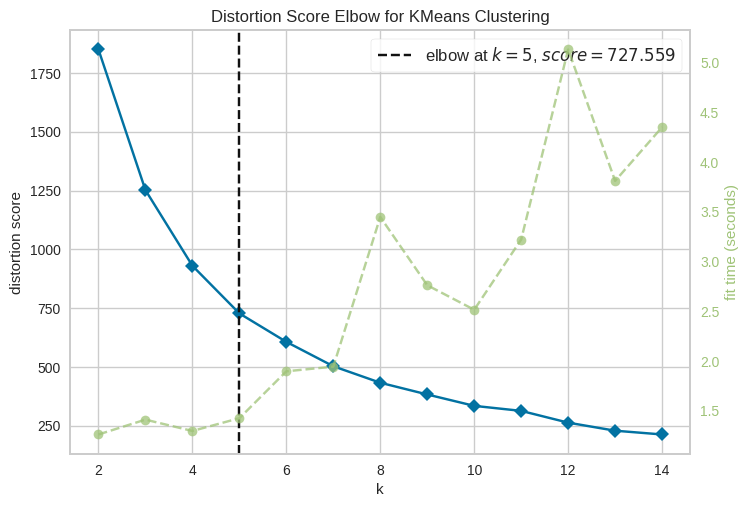

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [44]:
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
X_standardized = gptdf[cols]
visualizer = kelbow_visualizer(KMeans(), X_standardized,k=(2,15))
visualizer.fit(X_standardized)
visualizer.show()
num_comp = visualizer.elbow_value_

In [45]:
X_standardized = gptdf[cols]
n = num_comp  # Adjust as needed
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X_standardized)

# Create a DataFrame with the reduced dimensions
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n)])

gptdf.reset_index(drop=True, inplace=True)
pca_df.reset_index(drop=True, inplace=True)
# Concatenate the PCA components with other relevant columns
red_df = pd.concat([gptdf, pca_df], axis=1)
# Display the final DataFrame with reduced dimensions
red_df

user_id  fav_genre  average_duration    time_of_day  \
0       000052a0a0     Action          0.000248      Afternoon   
1       000296842d      Drama          0.001380  Early_morning   
2       0002aab109  Biography          0.005970          Night   
3       0005c8fbac  Adventure          0.033816          Night   
4       0005d9a8f4  Adventure          0.001028      Afternoon   
...            ...        ...               ...            ...   
106244  fffd345213  Adventure          0.000278  Early_morning   
106245  fffd4d1888     Action          0.000479          Night   
106246  fffd9bf758      Crime          0.000606      Afternoon   
106247  fffe7b777b      Drama          0.000127      Afternoon   
106248  fffeac83be      Drama          0.003189          Night   

         movie_preference  average_daily_duration  total_genres_watched  \
0         Old Movie Lover                0.000433                 0.250   
1       Into Recent Stuff                0.002759                 0.375   
2       Into Recent Stuff                0.005970                 0.125   
3         Old Movie Lover                0.033816                 0.500   
4       Into Recent Stuff                0.001028                 0.250   
...                   ...                     ...                   ...   
106244    Old Movie Lover                0.000278                 0.250   
106245  Into Recent Stuff                0.000479                 0.250   
106246  Into Recent Stuff                0.000606                 0.250   
106247  Into Recent Stuff                0.000127                 0.250   
106248  Into Recent Stuff                0.003986                 0.125   

       favorite_day_of_week  average_movie_duration  preferred_release_decade  \
0                   Tuesday                0.000248                       0.8   
1                    Sunday                0.001380                       0.9   
2                  Saturday                0.005970                       0.9   
3                    Friday                0.033816                       0.8   
4                    Monday                0.001028                       0.9   
...                     ...                     ...                       ...   
106244             Thursday                0.000278                       0.8   
106245               Friday                0.000479                       0.9   
106246            Wednesday                0.000606                       0.9   
106247             Saturday                0.000127                       0.9   
106248            Wednesday                0.003189                       0.9   

        ... watched_recently_released most_active_month  \
0       ...                         0               May   
1       ...                         0          December   
2       ...                         0               May   
3       ...                         0             March   
4       ...                         0           January   
...     ...                       ...               ...   
106244  ...                         0              July   
106245  ...                         0           January   
106246  ...                         0              June   
106247  ...                         0            August   
106248  ...                         0            August   

        preferred_genre_category longest_movie_watched genre_diversity_index  \
0                          Drama              0.000431                   1.0   
1                        Mystery              0.003447                   1.0   
2                      Biography              0.004585                   1.0   
3                      Animation              0.033082                   1.0   
4                      Adventure              0.000789                   1.0   
...                          ...                   ...                   ...   
106244                 Adventure              0.000213                   1.

### 2.3 Clustering!

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


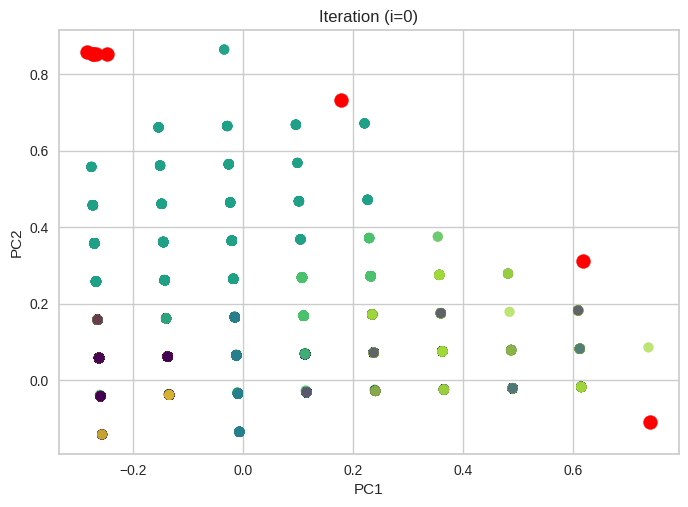

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


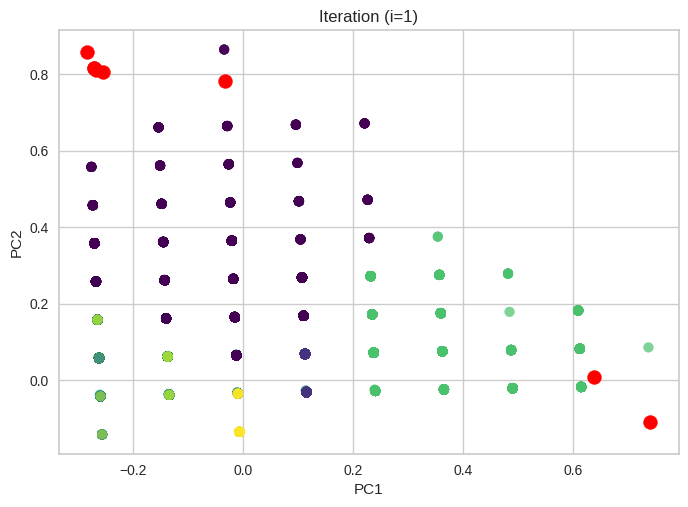

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


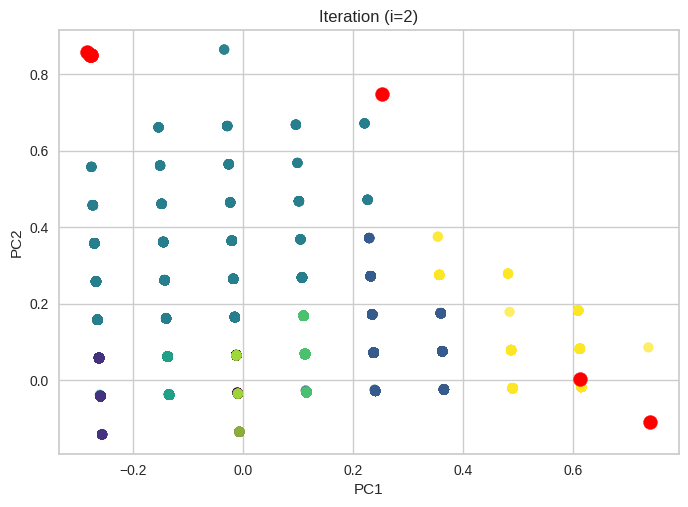

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


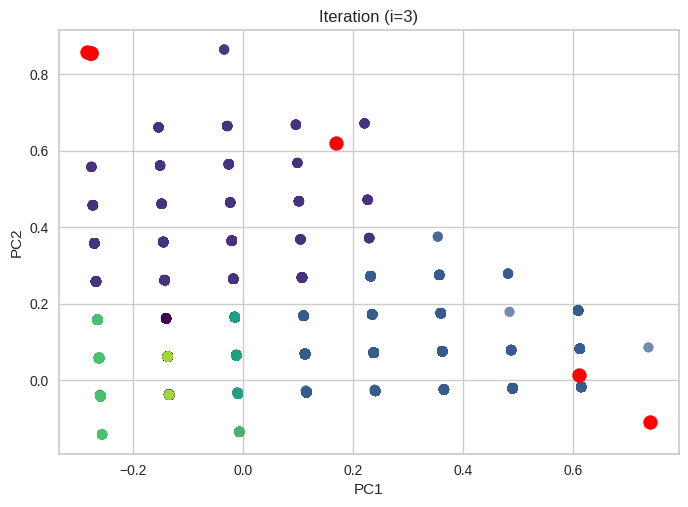

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


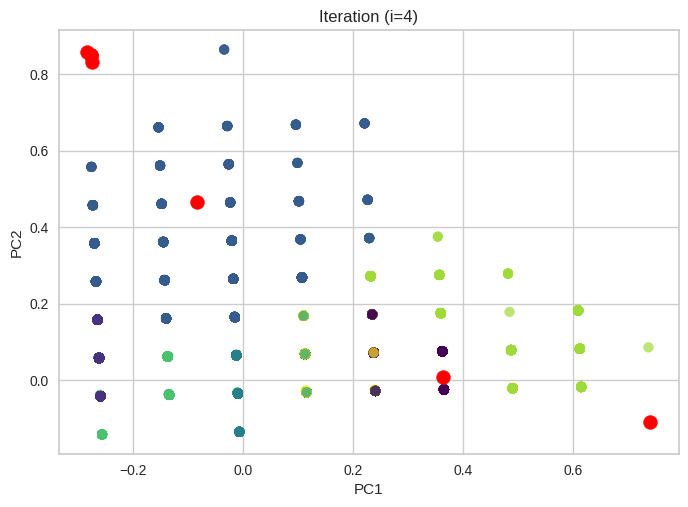

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


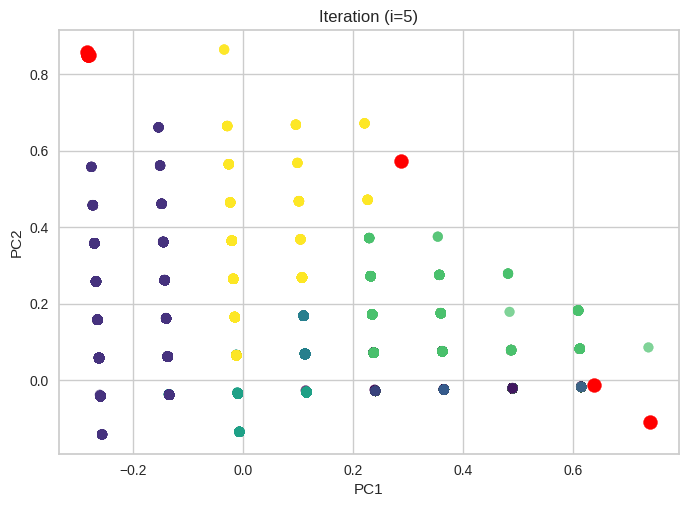

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


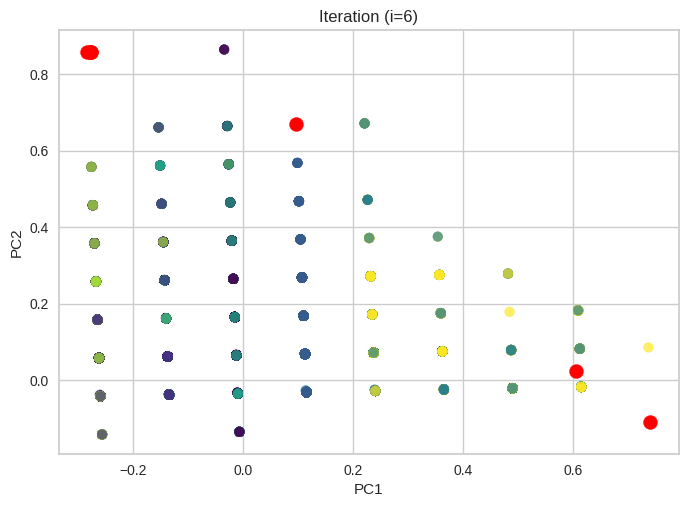

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


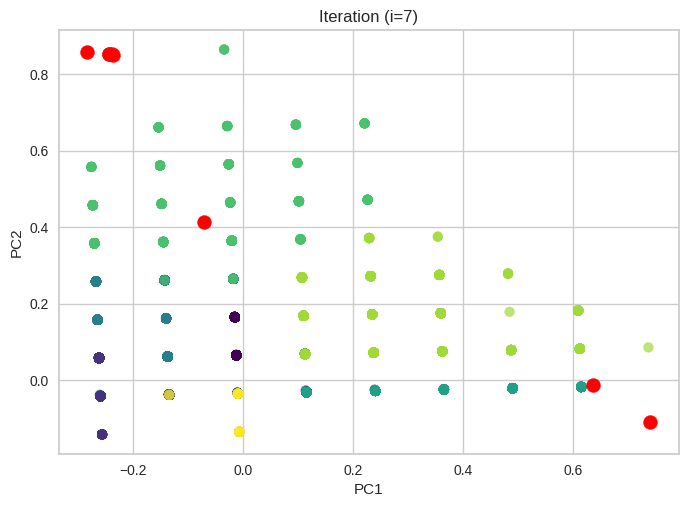

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


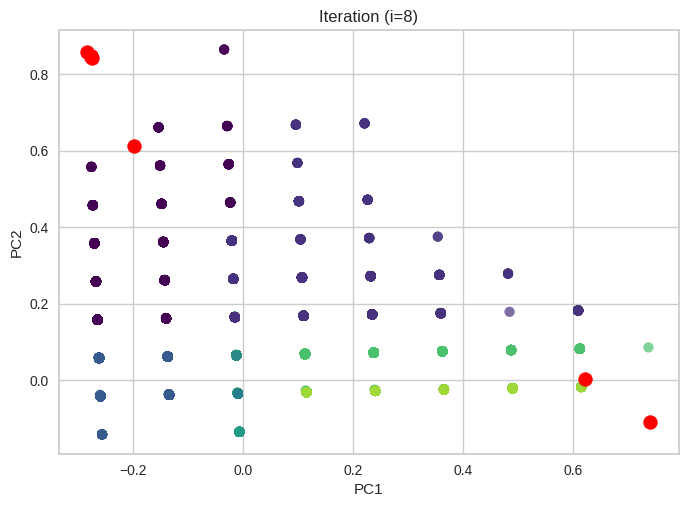

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


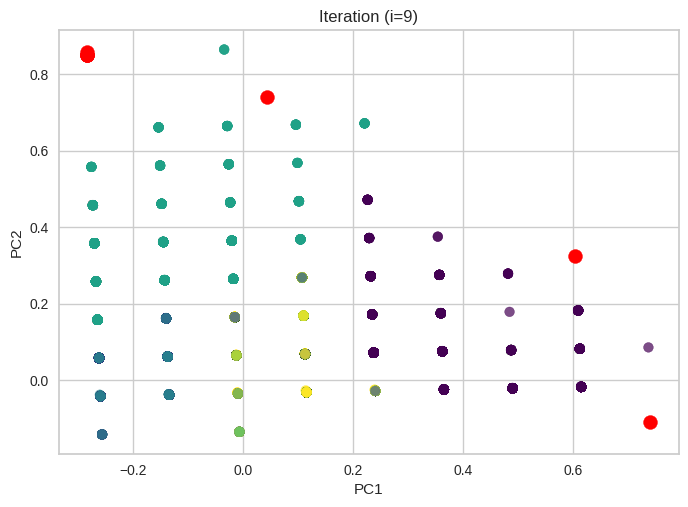

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


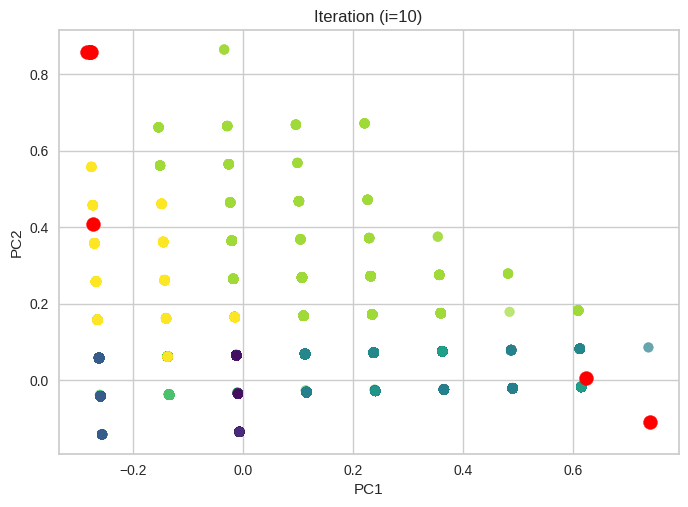

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


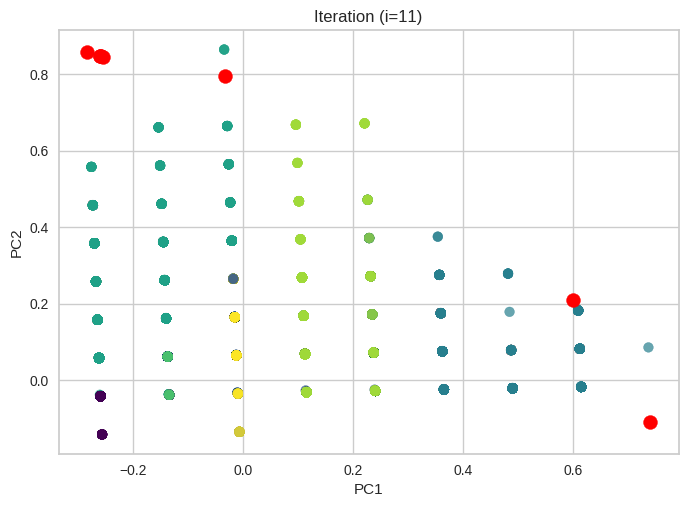

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


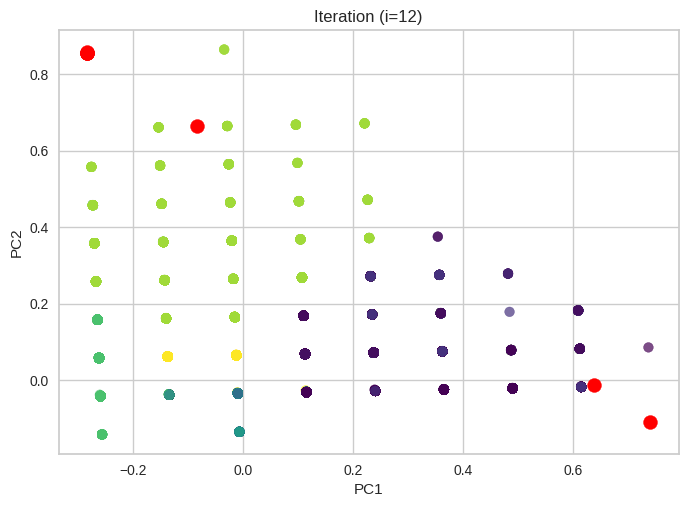

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


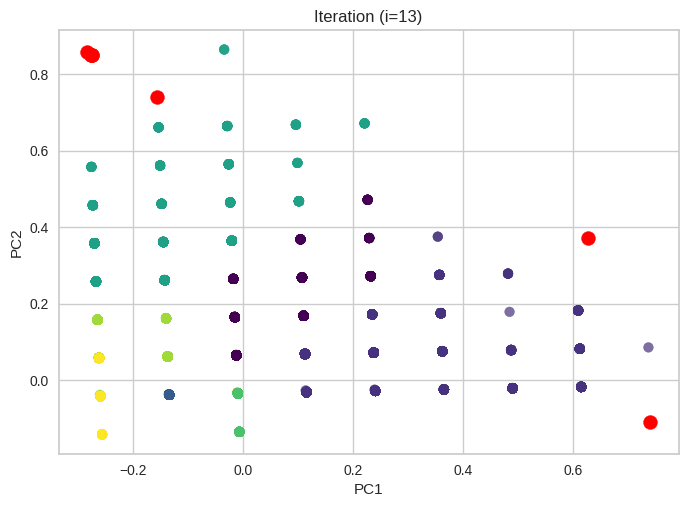

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


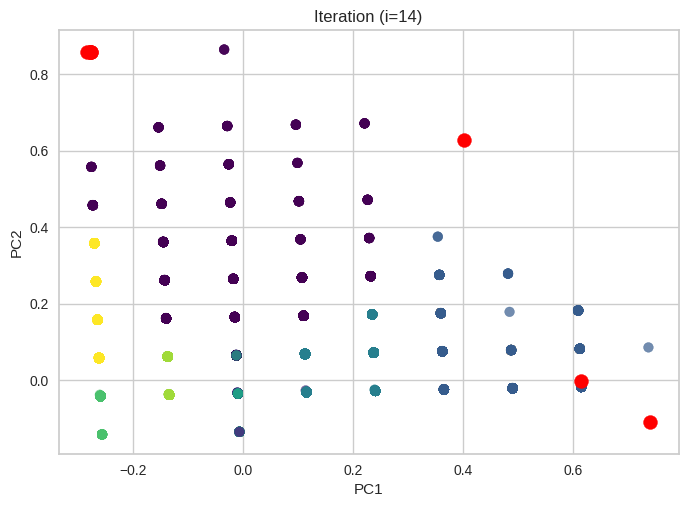

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


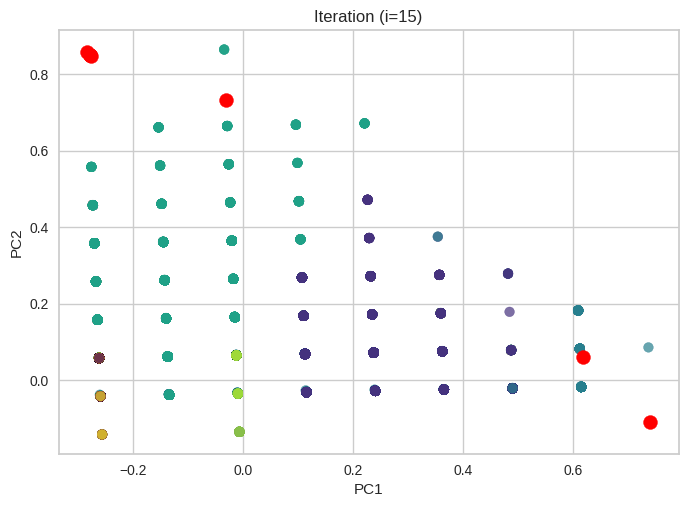

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


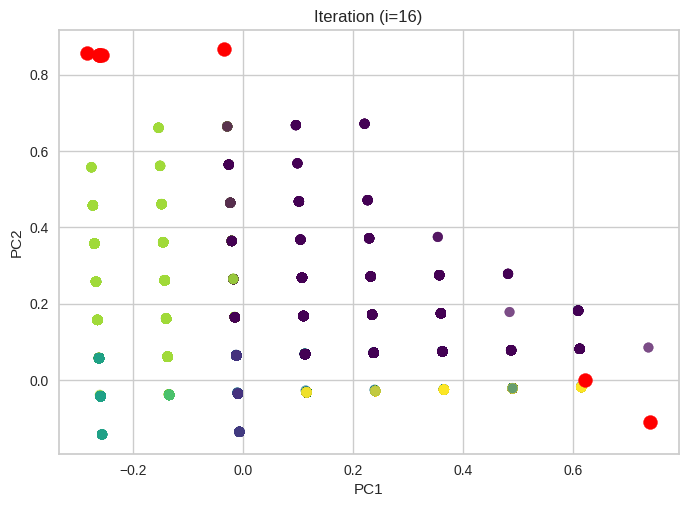

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


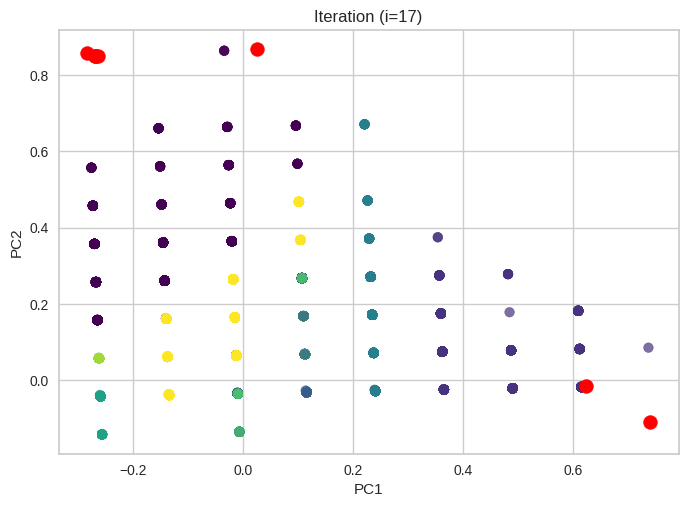

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


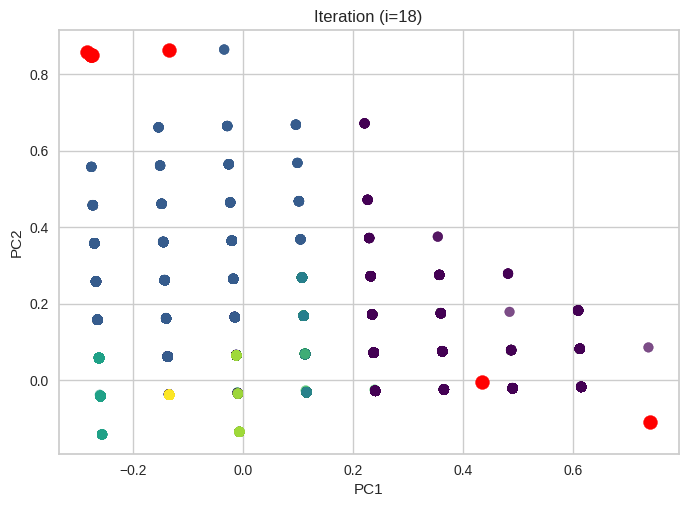

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


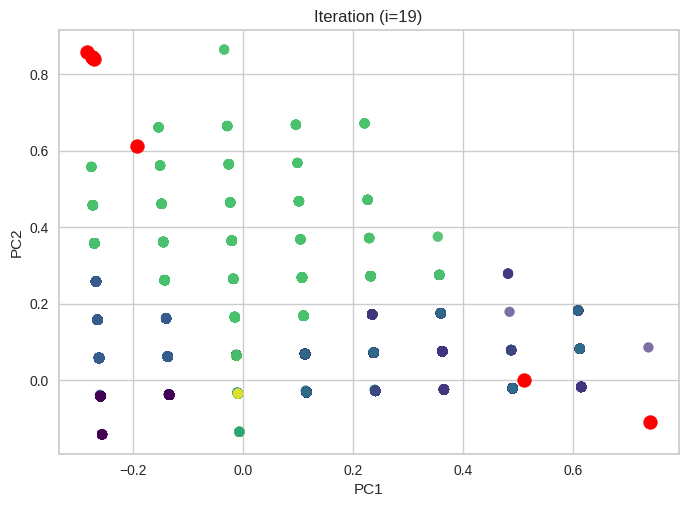

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


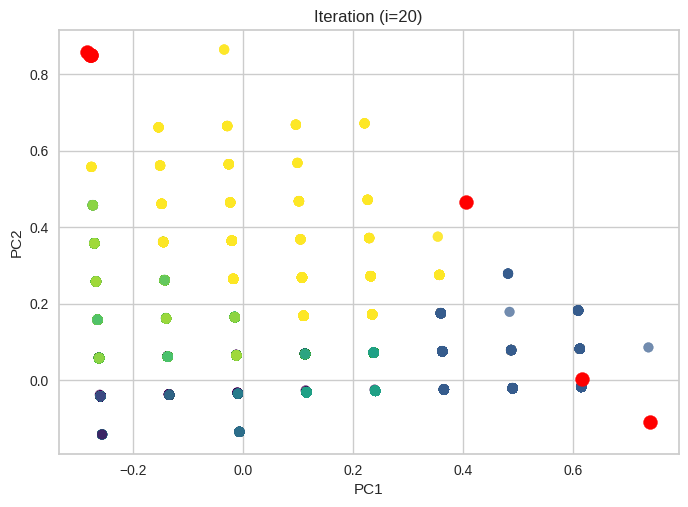

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


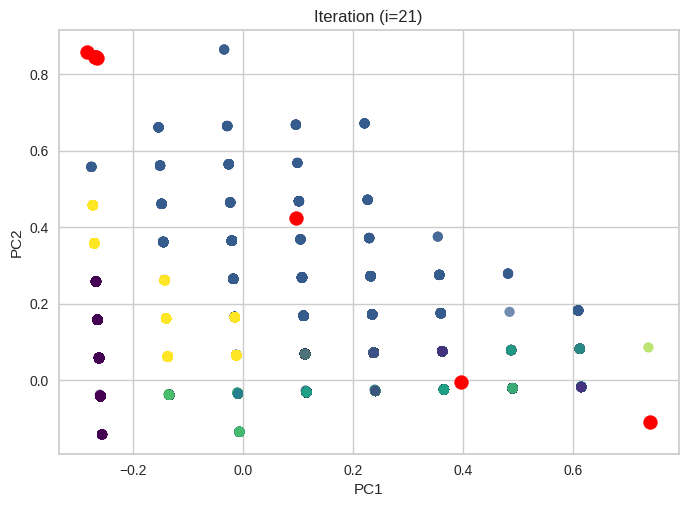

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


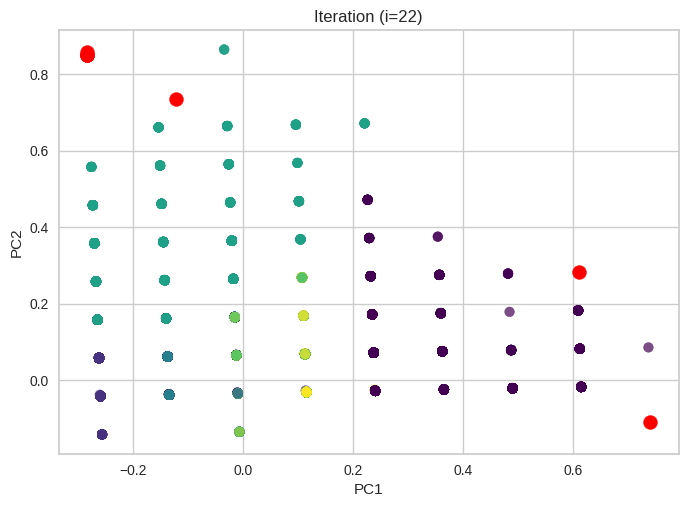

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


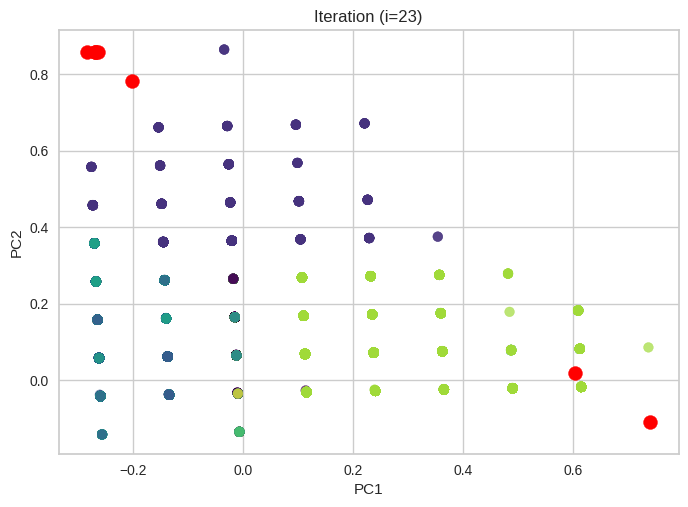

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


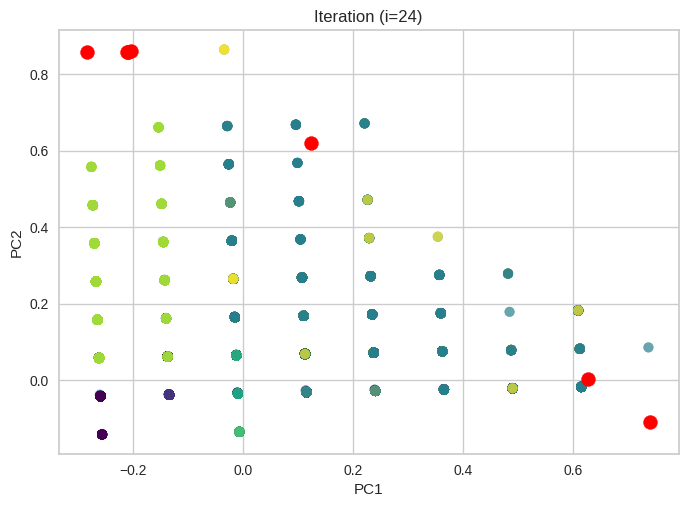

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


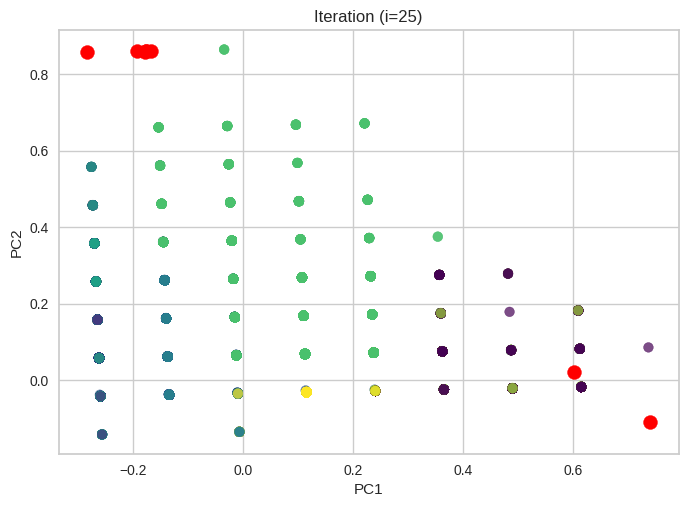

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


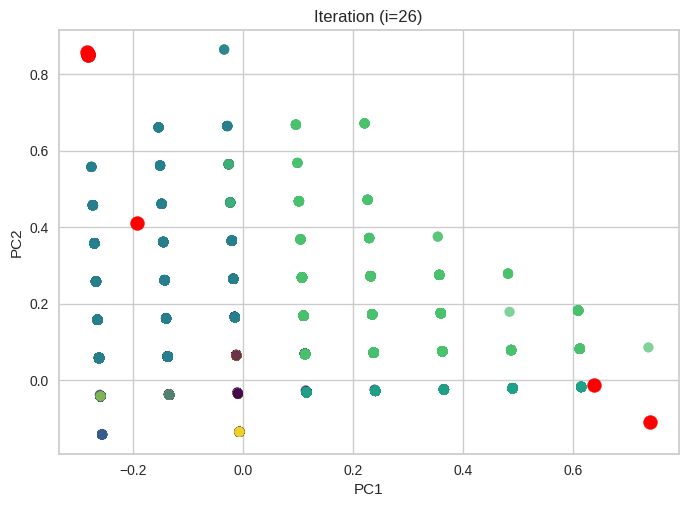

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


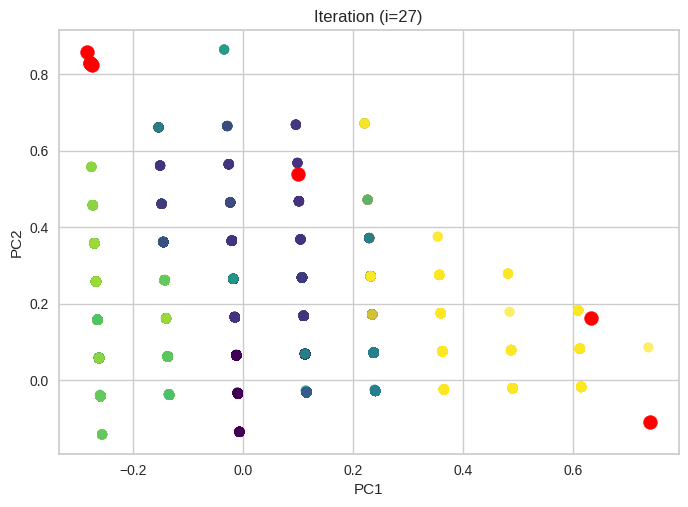

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


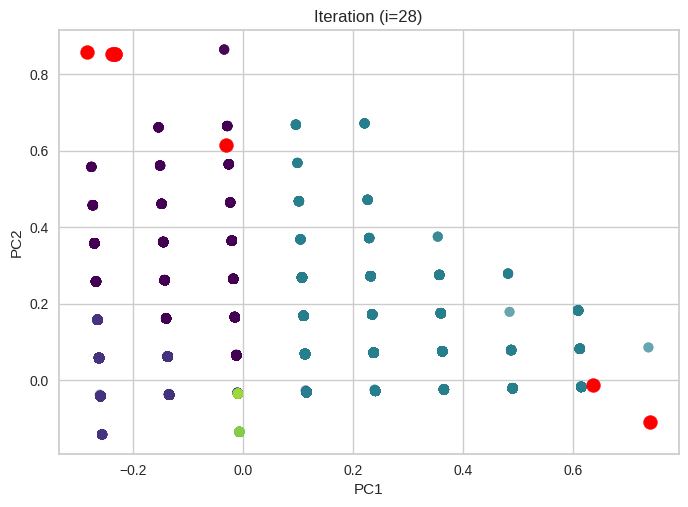

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


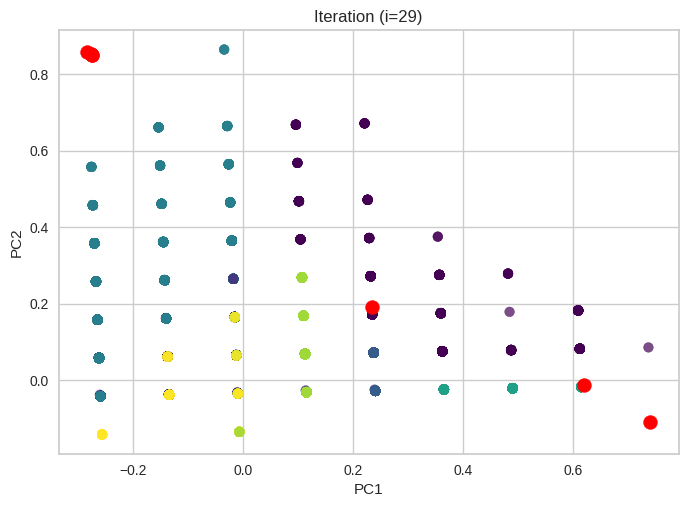

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


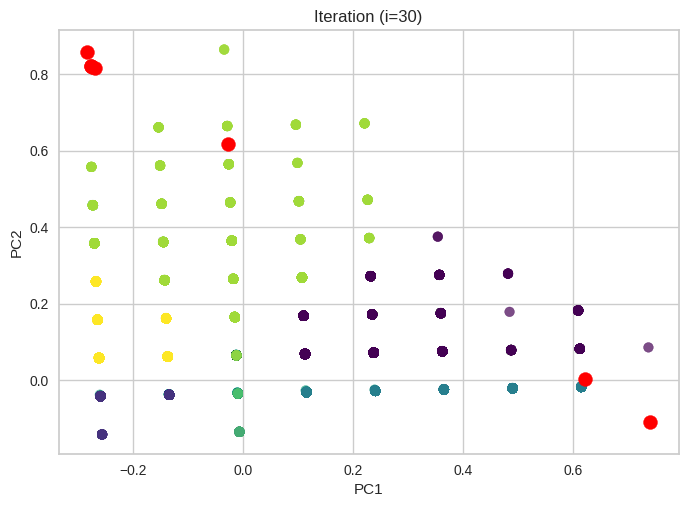

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


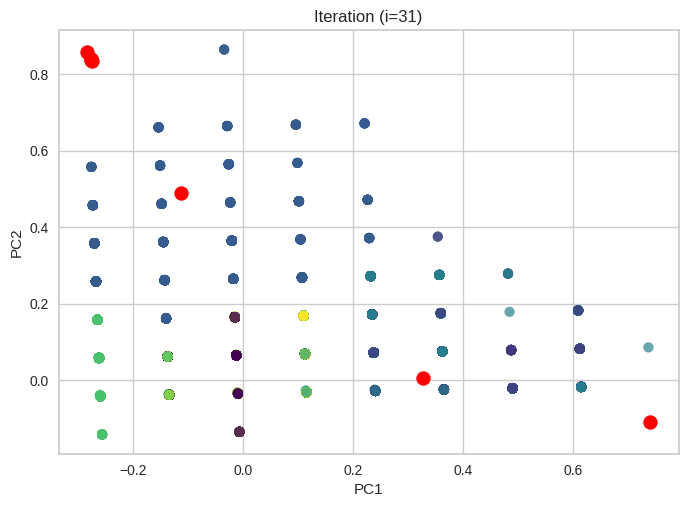

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


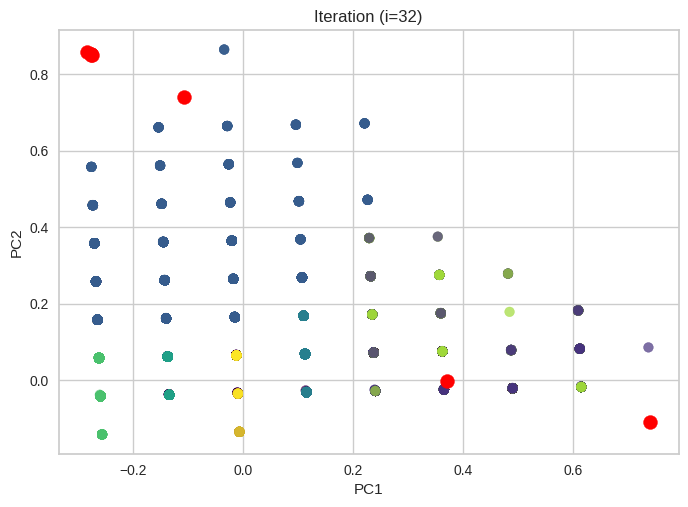

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


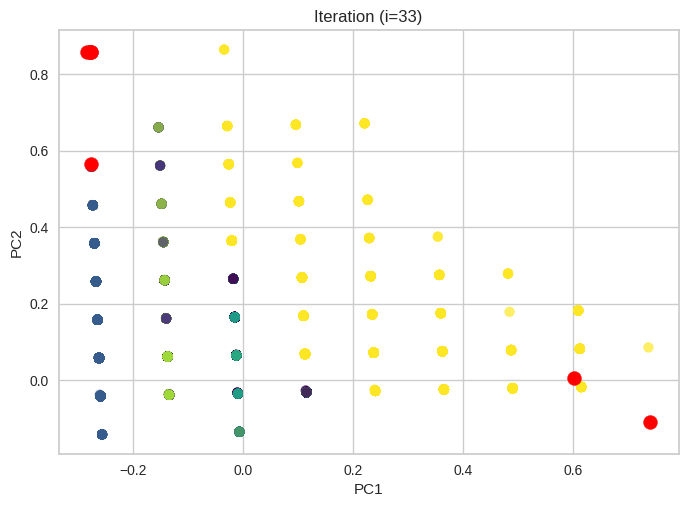

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


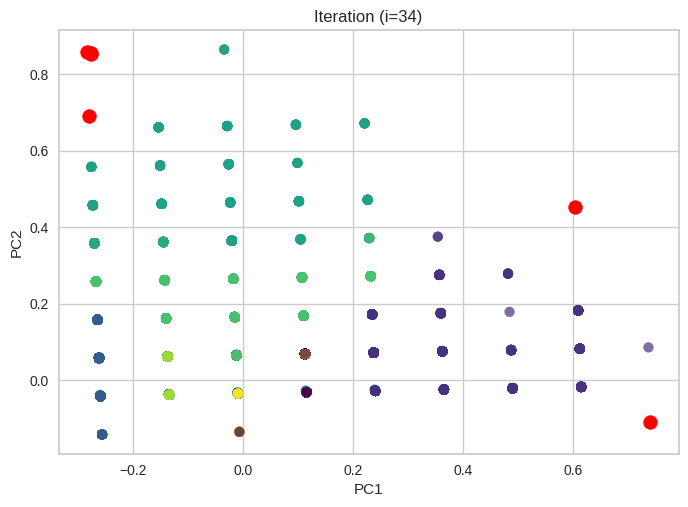

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


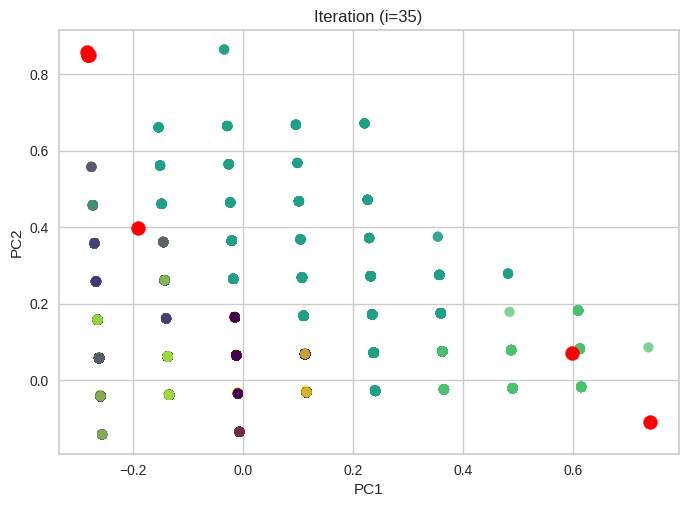

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


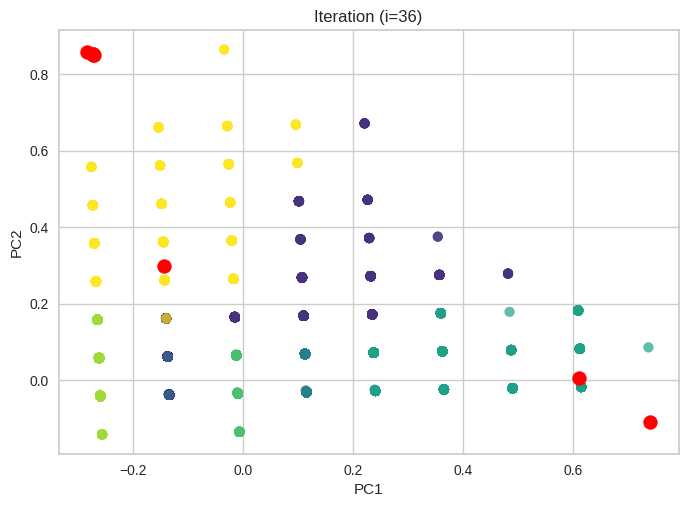

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


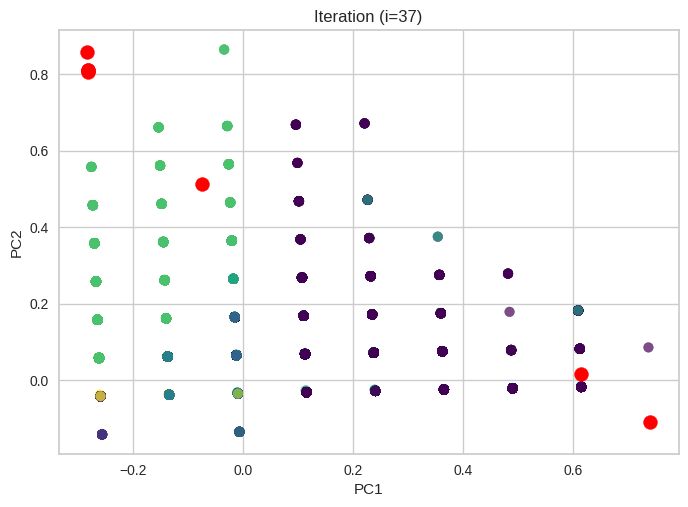

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


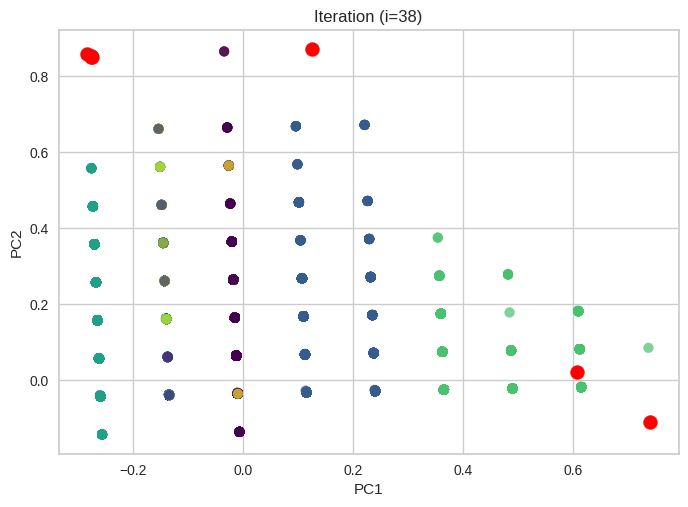

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


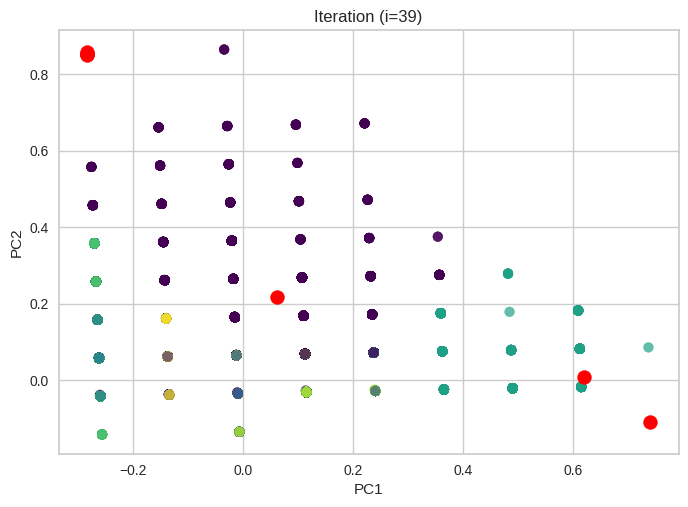

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


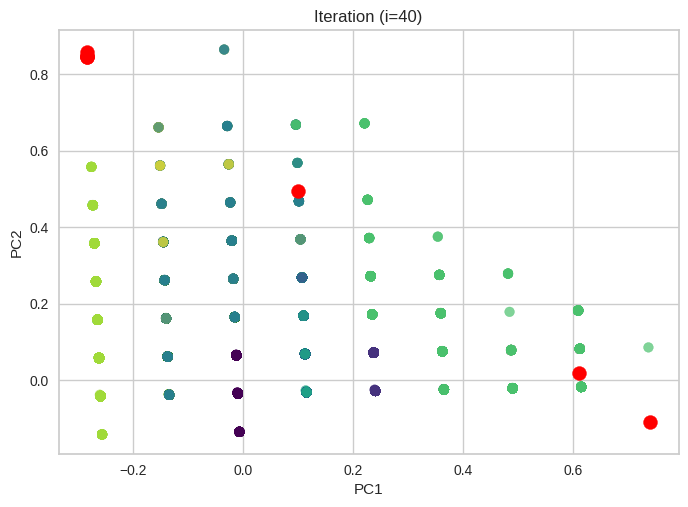

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


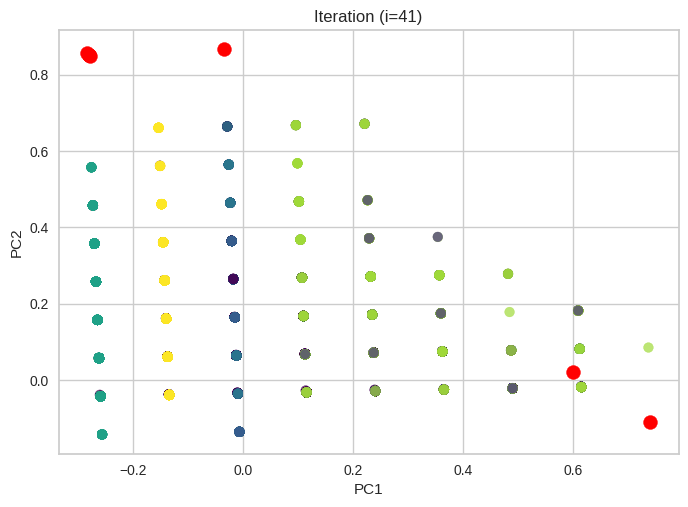

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


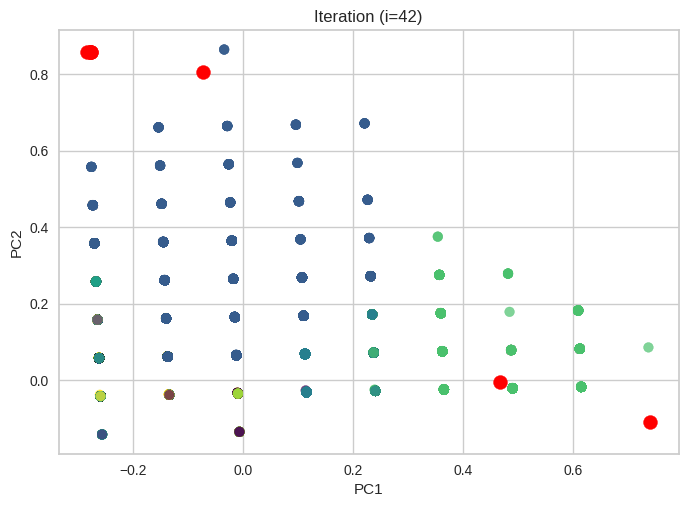

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


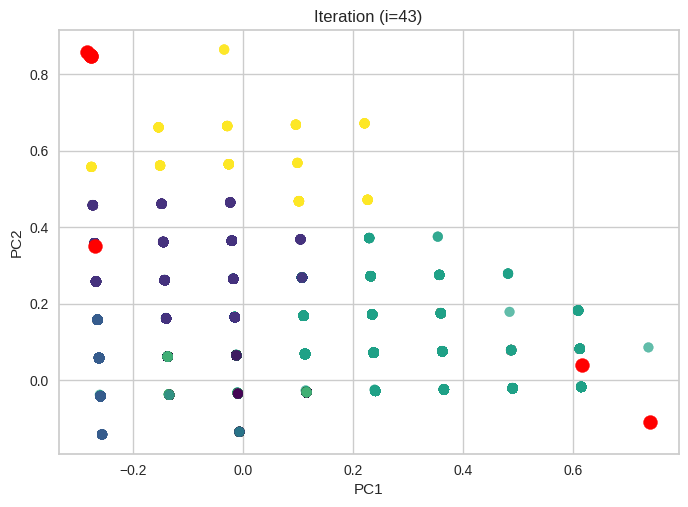

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


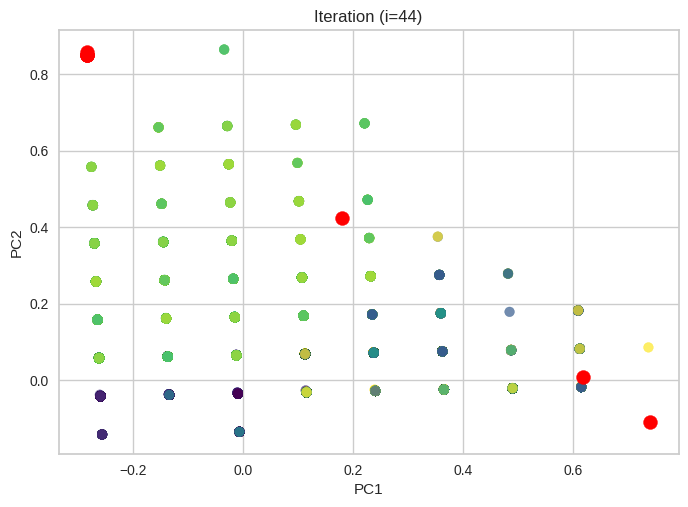

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


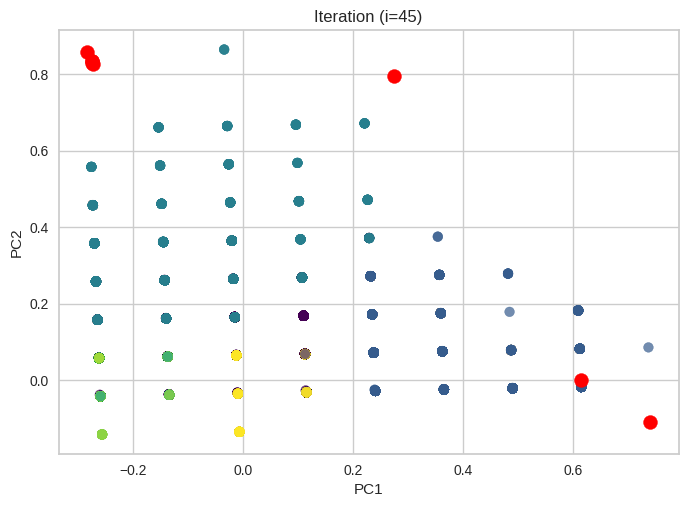

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


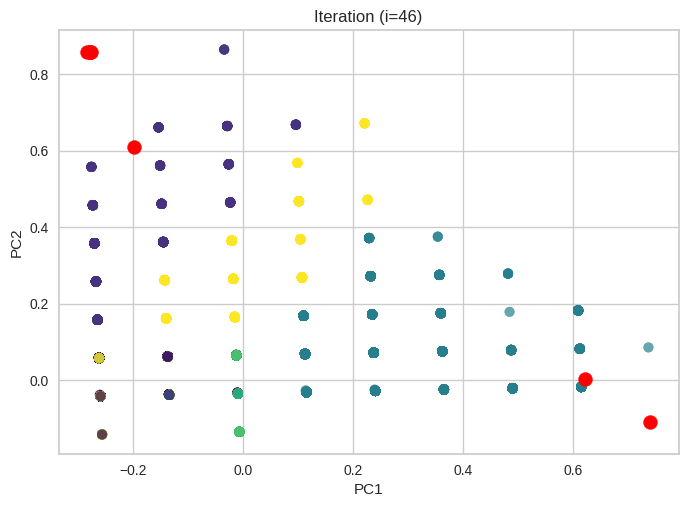

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


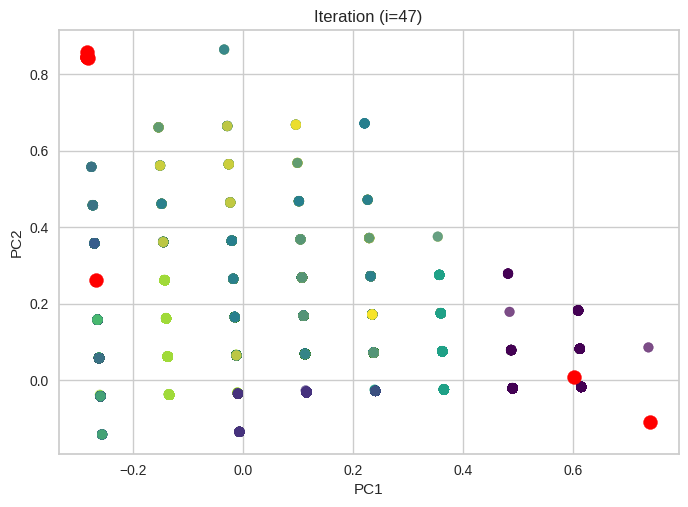

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


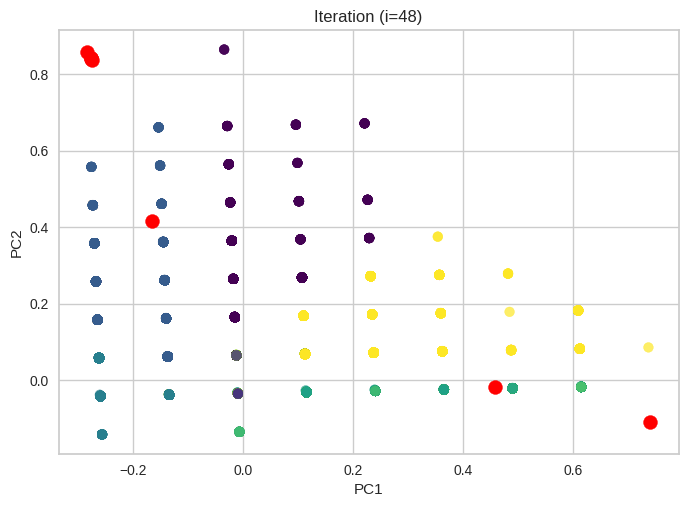

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


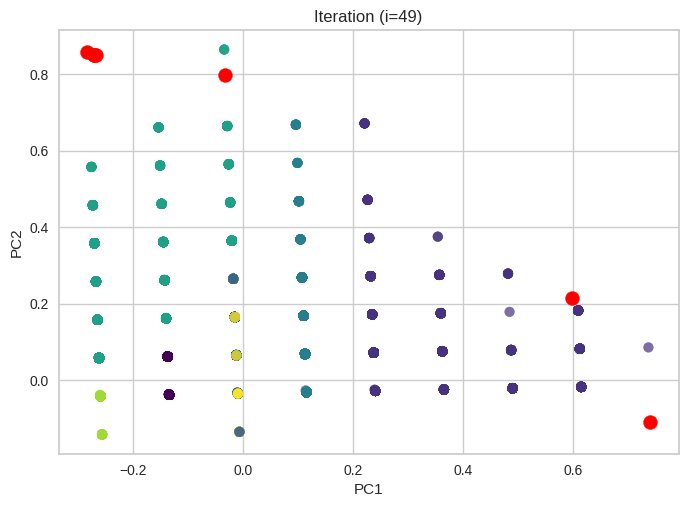

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


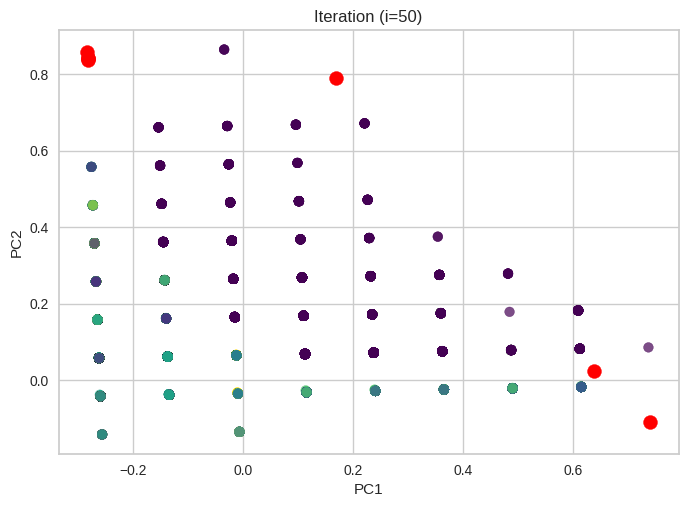

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


KeyboardInterrupt: ignored

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
k = 8
# Function to calculate Euclidean distances
def calculate_distances(df, centroids):
    return np.linalg.norm(df[:, np.newaxis] - centroids, axis=2)

# Function to perform one iteration of K-means
def kmeans_iteration(df, k):
    # Map
    centroids = df.sample(k)
    distances = calculate_distances(df.values, centroids.values)
    cluster_assignments = np.argmin(distances, axis=1)

    # Reduce
    new_centroids = df.groupby(cluster_assignments).mean().T

    return new_centroids, cluster_assignments

# Function to visualize clusters
def visualize_clusters(df, updated_centroids, cluster, i):
    pca = PCA(n_components=min(2, len(df.columns)))  # Ensure we don't request more PCs than available columns
    df_2d = pca.fit_transform(df)
    centroids_2d = pca.transform(updated_centroids)

    plt.scatter(df_2d[:, 0], df_2d[:, 1], c=cluster, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='red')
    plt.title(f'Iteration (i={i})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

# Function to check convergence
def has_converged(centroids, new_centroids):
    return new_centroids.equals(centroids)

# Assuming df is your original DataFrame
df = gptdf[cols]
centroids = None

# Run K-means for a maximum of 100 iterations
for i in range(100):
    new_centroids, cluster_assignment = kmeans_iteration(df, k)

    # Visualization
    visualize_clusters(df, new_centroids, cluster_assignment, i)

    # Check convergence
    if centroids is not None and has_converged(centroids, new_centroids):
        break

    # Update centroids for the next iteration
    centroids = new_centroids


### 2.3.2 Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

### Elbow Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

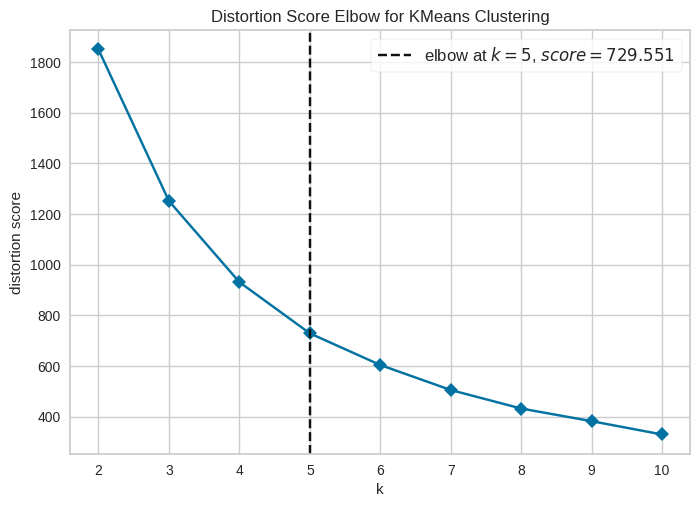

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Assuming df is your data
model = KMeans(random_state=42)

# Use the elbow method to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(2, 11), metric='distortion', timings=False)

# Fit the data to the visualizer
visualizer.fit(df)

# Visualize the elbow plot
visualizer.show()


In [49]:
optimal_k = visualizer.elbow_value_
print('Optimal K: ', optimal_k)

Optimal K:  5


### Silhouette Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

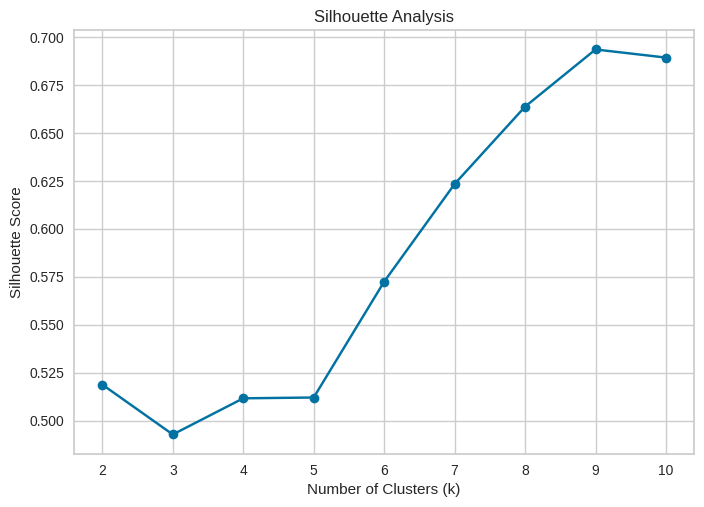

In [50]:
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

# Assuming df is your data
X = df.values

# Define a range of cluster numbers (k values)
k_values = range(2, 11)

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Iterate through different k values
for k in k_values:
    # Sample a subset of the data
    sample_size = min(500, len(X))  # Adjust the sample size based on your data size
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[sample_indices]

    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample)

    # Compute silhouette score
    silhouette_avg = silhouette_score(X_sample, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [51]:
silhouette_scores
optimal_k = np.argmax(silhouette_scores)
print('Optimal k is: ', optimal_k)

Optimal k is:  7


I would choose the one that consistently produces the highest or one of the highest average silhouette scores across different runs. This is because the silhouette score is a measure of the quality of the clustering, and it is a good indicator of how well the data points are grouped together.

In [52]:
def kmpp(df, k):
    i = np.random.randint(0, len(df))
    centroids = [df[i]]

    # Calculate the distances from the first centroid to all other dfpoints
    distances = np.linalg.norm(df- centroids[0], axis=1)

    # For the remaining centroids, iteratively choose dfpoints that have a probability proportional to their squared distance to the closest centroid
    for a in range(1, k):
        probability = distances / np.sum(distances)
        probs = probability / np.sum(probability)

        i = np.random.choice(len(df), p=probs)
        centroids.append(df[i])

        # Update the distances for the remaining centroids
        for j in range(len(centroids) - 1):
            distances[:, j] = np.minimum(distances[:, j], np.linalg.norm(df- centroids[-1], axis=1))

    return centroids


### 2.3.5
Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

According to ChatGPT clustering algorithms that you can consider:

1. **Agglomerative Hierarchical Clustering:** This algorithm builds a hierarchy of clusters. It starts with individual data points as clusters and then merges them to create a tree of clusters.

2. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):** This algorithm defines clusters as continuous regions of high data point density, separated by areas of lower density.

3. **Mean Shift:** This algorithm doesn't require specifying the number of clusters in advance. It works by identifying dense areas in the data and shifting points towards the mode of the data distribution.

4. **OPTICS (Ordering Points To Identify the Clustering Structure):** This algorithm is an extension of DBSCAN but provides more flexibility in identifying clusters of varying shapes and densities.

5. **Gaussian Mixture Models (GMM):** This algorithm models the data as a mixture of Gaussian distributions, allowing for more flexibility in cluster shape and size.


Great choice! Now, let's discuss why Mean Shift might be suitable for your data:

**Mean Shift:**

1. **No need to specify the number of clusters (K):** Mean Shift does not require you to specify the number of clusters in advance, making it flexible and suitable for cases where the optimal number of clusters is not known.

2. **Adaptive to cluster shape and size:** Mean Shift can identify clusters of various shapes and sizes, and it is not limited to spherical clusters, which is an advantage in scenarios where clusters may have different shapes.

3. **Robust to noise:** Mean Shift is robust to noise and can handle outliers well due to its density-based nature.

Now, let's implement Mean Shift using scikit-learn and run it on your data. After that, we can compare the results with K-Means and discuss any differences.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming df is your data
model = MiniBatchKMeans(n_clusters=8, random_state=42)

# Fit the model to the data
model.fit(df)

# Transform data for visualization
pca = PCA(n_components=2)
df_2d = pca.fit_transform(df)

# Visualize the clusters
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=model.labels_, cmap='viridis', alpha=0.7)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=100, c='red')
plt.title('MiniBatch KMeans Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


### 2.4 Analysing your results!
Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.

With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Time_Day variable:

In [ ]:
import pandas as pd
df = gptdf
# Calculate quartiles for each variable
df['time_of_day'] = pd.to_numeric(df['time_of_day'], errors='coerce')

df['Time_Day_Quartile'] = pd.qcut(df['time_of_day'], 4)
df['Average_Click_Duration_Quartile'] = pd.qcut(df['average_daily_duration'], 4)
df['Total_Genres_Watched_Quartile'] = pd.qcut(df['total_genres_watched'], 4)

# Create pivot tables for each variable
pivot_table_time_day = pd.pivot_table(df, values='time_of_day', index=['Time_Day_Quartile'], aggfunc='count')
pivot_table_average_click_duration = pd.pivot_table(df, values='average_daily_duration', index=['Average_Click_Duration_Quartile'], aggfunc='count')
pivot_table_total_genres_watched = pd.pivot_table(df, values='total_genres_watched', index=['Total_Genres_Watched_Quartile'], aggfunc='count')

print('Pivot table for ', time_of_day,':')
print(pivot_table_time_day)

print('Pivot table for ', average_daily_duration,':')
print(pivot_table_average_click_duration)

print('Pivot table for ', total_genres_watched,':')
print(pivot_table_total_genres_watched)


**************

# 4. Command Line Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tool that you know to answer the following questions using the same dataset that you have been using so far:
* What is the most-watched Netflix title?
* Report the average time between subsequent clicks on Netflix.com
* Provide the ID of the user that has spent the most time on Netflix

Important note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a screenshot of the output in the notebook for evaluation.

---
In order to solve this question we write a bash script that read the 'vodclickstream_uk_movies_03.csv' file to extract and analyse the data.

For the first question the code creates two temporary files that contains the list of the titles with no duplicate and the actual titles list. At this point starts a for loop in which for each title it counts the occurrances and an if statement determines the max.
In the second question we extract the duration column and with the grep command we delete the -1.0 values that doesn't make sense for a variable of type time. Then a for loop sum all the durations. At the end of the loop we divide the total by the number of cycles, hence the number of duration values.
In the third question we use temporary files in order to extract the list of the users and for each user all the duration values. Hence we sum the values and an if statement determines the max.

To run the code is necessary to install 'miller', that is a useful tool for working with data files as .csv. The installation is simple, using Ubuntu Linux you can write 'sudo apt-get install miller' on a terminal window.

In the beginning and in the end of the script there are the commands in order to print formatted output for a clearly visualization of the results.

In the end of the code there are also the commands for removing the temporary files used.

We write also the code for primitive status bars due to long script execution time.

---

The following cells contain the CommandLine.sh script and the output on a terminal window running the code on a local Ubuntu Linux machine:

In [ ]:
#!/bin/bash

#command useful in order to format the output
paint=$(tput rev)
no_paint=$(tput sgr 0)
blue=$(tput setaf 4)
red=$(tput setaf 1)
green=$(tput setaf 2)
yellow=$(tput setaf 3)


#printing formatted title and introduction
echo -e "\n"
echo "$paint$red                      COMMAND LINE QUESTION HW4 AMDM GROUP 21                         $no_paint"
echo "$paint$red  $no_paint                                                                                  $paint$red  $no_paint"
echo "$paint$red  $no_paint This bash script answers to the three questions from CLQ                         $paint$red  $no_paint"
echo "$paint$red  $no_paint                                                                                  $paint$red  $no_paint"
echo "$paint$red                                                                                      $no_paint"
echo -e "\n"
echo "Please make yourself comfortable, the code is going to run for a while: the machine is calculating untill you see the result on standard output."
echo "For a clearly visualization of the output it's recommended to maximize the terminal window."
echo "While the code is running a status bar will appear for each question: when you see ten times the symbol '#' the calculation for the specific question is complete."
echo -e "\n"

#-------------------------------------------


##############################
#                            #
# Most-watched Netflix title #--------------
#                            #
##############################

max_1=0
max_title=' '
i=1

#extracting the column 'title' from data, sorting with no duplicate
mlr --csv cut -o -f title vodclickstream_uk_movies_03.csv | sed 1d | sort -u > title.csv

#extracting the column 'title'
mlr --csv cut -o -f title vodclickstream_uk_movies_03.csv | sed 1d | sort > title_col.csv

#this command says to the for loop to consider the entire line as a variable
IFS=$'\n'

#inizialization of the status bar
echo -n 'Progress Q1: '

#for loop along all the titles
for title in $(cat 'title.csv')
do
    #l contains the occurrence of the title
    l=$(grep -i -F -c -x $title title_col.csv)

    #if statement in order to compare and extract the max
    if [ $l -ge $max_1 ]
    then
	max_1=$l
	max_title=$title
    fi

    #status bar update
    m=$((i%790))
    if [ $m == 0 ]
    then
	echo -n '#'
    fi

    i=$((i+1))

done

echo -e '\n'


################
#              #
# Average time #----------------------
#              #
################

average=0
p=0
i=1

#extracting the column 'duration'
mlr --csv cut -o -f duration vodclickstream_uk_movies_03.csv | sed 1d | sort > duration_col.csv

#remove -1.0 values
grep -i -v '\-1\.0' duration_col.csv > dur_grep.csv

IFS=$'\n'

echo -n 'Progress Q2: '

#for loop along the duration column
for duration in $(cat 'dur_grep.csv')
do
    #sum
    average=$(echo "scale=3;$average+$duration" | bc)

    #counter for the final division
    p=$((p+1))

    #status bar
    m=$((i%65000))
    if [ $m == 0 ]
    then
	echo -n '#'
    fi

    i=$((i+1))
done

#actual average
average=$(echo "scale=3;$average/$p" | bc)

echo -e '\n'


################
#              #
# Most user    #----------------------
#              #
################

max_2=0.0
max_user=' '
i=1

#extracting the duration and user_id column
mlr --csv cut -o -f duration,user_id vodclickstream_uk_movies_03.csv > user_dur.csv

#extracting only the user_id column
mlr --csv cut -o -f user_id vodclickstream_uk_movies_03.csv | sed 1d | sort -u > user.csv

echo -n 'Progress Q3: '

#for loop along all the users
for user in $(cat 'user.csv')
do
    #insert the headers
    head -n1 user_dur.csv > user_grep.csv

    #appending only the lines of the current user
    grep $user user_dur.csv >> user_grep.csv

    #removing the 0.0 and -1.0 values
    grep -i -v '\<0\.0\>' user_grep.csv | grep -i -v '\-1\.0' > user_grep_2.csv

    #extracting only the duration column for the current user without the header
    mlr --csv cut -o -f duration user_grep_2.csv | sed 1d > file_1.csv

    #inizialization of the variable that will contain the total duration for the user
    t=0.0

    #for loop along all the duration for the current user
    for dur in $(cat 'file_1.csv')
    do
	#sum
	t=$(echo "scale=3;$t+$dur" | bc)
    done

    #if statement in order to compare and extract the max
    if [ $(echo "$t>$max_2" | bc -l) -eq 1 ]
    then
	max_2=$t
        max_user=$user
    fi

    #status bar
    m=$((i%16190))
    if [ $m == 0 ]
    then
	echo -n '#'
    fi

    i=$((i+1))

done

echo -e '\n'

#-----------------------------------------------

#removing the temporary files used for the analysis
rm title.csv
rm title_col.csv
rm duration_col.csv
rm dur_grep.csv
rm user_dur.csv
rm user.csv
rm user_grep.csv
rm user_grep_2.csv
rm file_1.csv


#printing formatted output question 1
echo "$paint$blue    QUESTION 1: WHAT IS THE MOST-WATCHED NETFLIX TITLE?                               $no_paint"
echo "$paint$blue  $no_paint                                                                                  $paint$blue  $no_paint"
echo "$paint$blue  $no_paint The most-watched netflix title is:                                               $paint$blue  $no_paint"
echo "$paint$blue  $no_paint "$max_title" with "$max_1" clicks                                      $paint$blue  $no_paint"
echo "$paint$blue  $no_paint                                                                                  $paint$blue  $no_paint"
echo "$paint$blue                                                                                      $no_paint"

#question 2
echo "$paint$green    QUESTION 2: REPORT THE AVERAGE TIME BETWEEN SUBSEQUENT CLICKS ON NETFLIX.COM      $no_paint"
echo "$paint$green  $no_paint                                                                                  $paint$green  $no_paint"
echo "$paint$green  $no_paint The average time between subsequent clicks on Netflix.com is:                    $paint$green  $no_paint"
echo "$paint$green  $no_paint "$average" s, hence about 9 hours                                                 $paint$green  $no_paint"
echo "$paint$green  $no_paint                                                                                  $paint$green  $no_paint"
echo "$paint$green                                                                                      $no_paint"

#question 3
echo "$paint$yellow    QUESTION 3: PROVIDE THE ID OF THE USER THAT HAS SPENT THE MOST TIME ON NETFLIX    $no_paint"
echo "$paint$yellow  $no_paint                                                                                  $paint$yellow  $no_paint"
echo "$paint$yellow  $no_paint The user that has spent the most time on netflix is:                             $paint$yellow  $no_paint"
echo "$paint$yellow  $no_paint "$max_user" with "$max_2" seconds, hence about 245 days                         $paint$yellow  $no_paint"
echo "$paint$yellow  $no_paint                                                                                  $paint$yellow  $no_paint"
echo "$paint$yellow                                                                                      $no_paint"

echo -e "\n"


![output_screenshot](CommandLine_output_screen.png)

The most-watched title is Black Mirror: Bandersnatch. The average time between subsequent clicks on Netflix site is 34595 seconds: about 9 hours, a big value. The user that has spent the most time on Netflix is '322abe045c' with around 245 days.

*****

# 5. Algorithmic Question (AQ)

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In [ ]:
def High_score(current_score, exam_scores, index=1):
    if len(exam_scores) == 1:
        return exam_scores[0]

    if index == 1 and len(exam_scores) % 2 == 0:
        index += 1

    if index % 2 != 0:
        next_score = max(exam_scores)
        adjustment = next_score - current_score
        sorted_exam_scores = sorted(exam_scores, reverse=True)

        remaining_scores = []
        for num in sorted_exam_scores[1:]:
            remaining_scores.append(num - adjustment)
    else:
        next_score = min(exam_scores)
        adjustment = current_score - next_score
        sorted_exam_scores = sorted(exam_scores)

        remaining_scores = []
        for num in sorted_exam_scores[1:]:
            remaining_scores.append(num + adjustment)

    return High_score(next_score, remaining_scores, index + 1)

# Example inputs
initial_score1 = 8
exam_scores1 = [5, 7, 1]
result1 = High_score(initial_score1, exam_scores1)
print("Output 1 result =", result1)

initial_score2 = 25
exam_scores2 = [18, 24, 21, 32, 27]
result2 = High_score(initial_score2, exam_scores2)
print("Output 2 result =", result2)

initial_score3 = 30
exam_scores3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = High_score(initial_score3, exam_scores3)
print("Output 3 result =", result3)

Output 1 result = 11
Output 2 result = 44
Output 3 result = 205


b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!



The time complexity of the code depends principally from:
* the sorted() function has a complexity of O(n log(n))
* the iterations have a linear complexity of O(n)



So the final complexity of the High_score function is O(n log(n)) which is a good result

c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

* The result obrìtained before is good as it has a good O notation, i tried to implement the  "memoization" technique but i didn't manage to improve the time complexity. The complexity of the previous function could be considered fast enough to keep it as a final answer

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!



In [ ]:
def High_score_memo(current_score, exam_scores, index=1, memo={}):
    if len(exam_scores) == 1:
        return exam_scores[0]

    if index == 1 and len(exam_scores) % 2 == 0:
        index += 1

    if (current_score, index, tuple(exam_scores)) in memo:
        return memo[(current_score, index, tuple(exam_scores))]

    if index % 2 != 0:
        next_score = max(exam_scores)
        adjustment = next_score - current_score
        sorted_exam_scores = sorted(exam_scores, reverse=True)

        remaining_scores = [num - adjustment for num in sorted_exam_scores[1:]]
    else:
        next_score = min(exam_scores)
        adjustment = current_score - next_score
        sorted_exam_scores = sorted(exam_scores)

        remaining_scores = [num + adjustment for num in sorted_exam_scores[1:]]

    result = High_score_memo(next_score, remaining_scores, index + 1, memo)
    memo[(current_score, index, tuple(exam_scores))] = result
    return result

# Example inputs
initial_score1 = 8
exam_scores1 = [5, 7, 1]
result1 = High_score_memo(initial_score1, exam_scores1)
print("Output 1 result =", result1)

initial_score2 = 25
exam_scores2 = [18, 24, 21, 32, 27]
result2 = High_score_memo(initial_score2, exam_scores2)
print("Output 2 result =", result2)

initial_score3 = 30
exam_scores3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = High_score_memo(initial_score3, exam_scores3)
print("Output 3 result =", result3)


Output 1 result = 11
Output 2 result = 44
Output 3 result = 205


In this version, the memo dictionary is used to store previously calculated results. The memoized approach reduces redundant calculations and makes the function more efficient, resulting in a lower time complexity. The chatbot used memoization in an efficient way to reduce the time complexity

The output from chatGPT is :
* The introduction of memoization significantly reduces redundant calculations. Memoization ensures that each unique combination of parameters (current_score, index, tuple(exam_scores)) is computed only once and stored in the memo dictionary. As a result, the depth of the recursion tree is limited to the number of unique subproblems, which is much smaller than 2^n. In the best case, where many subproblems are reused, the time complexity is significantly reduced.

* The time complexity of the optimized function with memoization can be considered approximately O(n * m), where n is the length of exam_scores, and m is the average number of unique subproblems for each function call. The exact value of m depends on the specific characteristics of the input data.

* It's important to note that providing an exact closed-form expression for the time complexity of a memoized recursive function can be challenging, and the notation may vary based on the characteristics of the input data. The memoized version, however, is expected to be significantly more efficient than the original version in practice, especially for larger input sizes.





